<a href="https://colab.research.google.com/github/marklerd/projects/blob/main/5005_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score, roc_curve, precision_recall_curve, auc
from IPython.display import display, HTML
from scipy.stats import norm



In [ ]:
# load data
df_total = pd.read_csv('training_df.csv', index_col=0)

These are Data preprocessing steps

In [ ]:
# Check for missing values in each column
missing_values = df_total.isnull().sum()
print("Missing Values:")
print(missing_values)

# Check if any missing values exist in the DataFrame
any_missing = df_total.isnull().any().any()
print("\nAny Missing Values:", any_missing)

# Check for duplicate rows
duplicate_rows = df_total.duplicated()
num_duplicates = duplicate_rows.sum()
print("\nNumber of Duplicate Rows:", num_duplicates)

# No missing or duplicates

Missing Values:
Trial.ID                      0
resp.pCR                      0
resp.Chemosensitive           0
resp.Chemoresistant           0
RCB.score                     0
                             ..
Chemo.first.Anthracycline     0
Chemo.second.Taxane           0
Chemo.second.Anthracycline    0
Chemo.any.Anthracycline       0
Chemo.any.antiHER2            0
Length: 73, dtype: int64

Any Missing Values: False

Number of Duplicate Rows: 0


In [ ]:
# outcome columns
outcome_columns = ['resp.pCR', 'resp.Chemosensitive', 'resp.Chemoresistant',
       'RCB.score', 'RCB.category']

# Define target as y, for complete resolution in 'resp.pCR encodeed as 0 = No, 1 = Yes
#y = df_total['RCB.category']
y = df_total['resp.pCR']

# store outcome as separate df just in case
outcome_df = df_total[outcome_columns]

# drop outcome columns
df = df_total.drop(outcome_columns, axis=1)

# check remaining columns number
print(len(df.columns))

# 'resp.pCR', 'resp.Chemosensitive', 'resp.Chemoresistant' = nominal_features
# 'RCB.score' = numeric_features

68


I will be using 2 different amount of data to train model
1. only data used in the study, the features were selected based on their association with outcomes
2. use all data available

In [ ]:
# features used by study
st_other = ['Trial.ID', 'resp.pCR', 'resp.Chemosensitive', 'resp.Chemoresistant', 'RCB.score', 'RCB.category']
st_clin = ['Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'LN.at.diagnosis', 'Grade.pre.chemotherapy', 'Size.at.diagnosis']
st_clinplus =['ER.Allred']
st_digpath = ['median_lymph_KDE_knn_50']
st_dna = ['All.TMB', 'Coding.TMB', 'Expressed.NAg', 'CodingMuts.PIK3CA', 'CodingMuts.TP53', 'CIN.Prop', 'HLA.LOH', 'HRD.sum']
st_rna = ['STAT1.ssgsea.notnorm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'CytScore.log2', 'Swanton.PaclitaxelScore', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells']
st_chemo = ['Chemo.NumCycles', 'Chemo.first.Taxane', 'Chemo.second.Taxane', 'Chemo.any.Anthracycline', 'Chemo.any.antiHER2']

In [ ]:
# Combine all features used in the study into a single list
st_comparison_list = st_clin + st_digpath + st_dna + st_rna + st_chemo

# find features that are not used in the study
not_in_comparison = [item for item in df.columns if item not in st_comparison_list]

# Drop the columns with unused features and call this partial_df
partial_df = df.drop(not_in_comparison, axis=1)

# Name df with only features used in the study 'partial_df'
partial_df.name = 'partial_df'

# get shape
partial_df.shape

(147, 32)

In [ ]:
# All features available from the dataset
t_clin = ['Age.at.diagnosis', 'Histology', 'ER.status', 'HER2.status', 'LN.at.diagnosis', 'Grade.pre.chemotherapy', 'Size.at.diagnosis','ER.Allred']
t_digpath = ['median_lymph_KDE_knn_50']
t_dna = ['All.TMB', 'Coding.TMB', 'Expressed.NAg', 'CodingMuts.PIK3CA', 'CodingMuts.TP53', 'CIN.Prop', 'HLA.LOH', 'HRD.sum','HRD.LOH','HRD.TelomericAI', 'HRD.LST']
t_rna = ['STAT1.gsva', 'GGI.gsva', 'GEP.gsva','ESC.gsva','STAT1.ssgsea.norm', 'GGI.ssgsea.norm', 'GEP.ssgsea.norm','ESC.ssgsea.norm', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm', 'CytScore.log2', 'Swanton.PaclitaxelScore','Swanton.MitosisScore', 'Swanton.CeramideScore','TIDE.MDSC', 'TIDE.CAF', 'TIDE.TAM.M2', 'TIDE.IFNG', 'TIDE.CD274', 'TIDE.CD8', 'TIDE.Dysfunction', 'TIDE.Exclusion', 'Danaher.Mast.cells','Danaher.B.cells', 'Danaher.CD45', 'Danaher.CD8.T.cells', 'Danaher.Cytotoxic.cells', 'Danaher.DC', 'Danaher.Exhausted.CD8', 'Danaher.Macrophages', 'Danaher.Neutrophils', 'Danaher.NK.CD56dim.cells', 'Danaher.NK.cells', 'Danaher.T.cells', 'Danaher.Th1.cells', 'Danaher.Treg']
t_chemo = ['Chemo.NumCycles', 'Chemo.first.Taxane', 'Chemo.first.Anthracycline', 'Chemo.second.Taxane', 'Chemo.second.Anthracycline', 'Chemo.any.Anthracycline', 'Chemo.any.antiHER2']

# get list of all features
t_comparison_list = t_clin + t_digpath + t_dna + t_rna + t_chemo

# find any features not in list (outcome features and id)
not_in_comparison = [item for item in df.columns if item not in t_comparison_list]

# Drop columns that are not features
t_df = df.drop(not_in_comparison, axis=1)

# Name df with all features available 'full_df'
t_df.name = 'full_df'

# get shape
t_df.shape


(147, 64)

In [ ]:
# Define data types of each feature
numeric_features = ['Age.at.diagnosis','Size.at.diagnosis','median_lymph_KDE_knn_50','All.TMB',
                    'Coding.TMB', 'Expressed.NAg','CIN.Prop','HRD.LOH', 'HRD.TelomericAI', 'HRD.LST',
                    'HRD.sum', 'STAT1.gsva', 'GGI.gsva', 'GEP.gsva', 'ESC.gsva',
                    'STAT1.ssgsea.norm', 'GGI.ssgsea.norm', 'GEP.ssgsea.norm',
                    'ESC.ssgsea.norm','STAT1.ssgsea.notnorm', 'GGI.ssgsea.notnorm', 'ESC.ssgsea.notnorm', 'PGR.log2.tpm', 'ESR1.log2.tpm', 'ERBB2.log2.tpm',
                    'CytScore.log2', 'Swanton.MitosisScore', 'Swanton.CeramideScore',
                    'Swanton.PaclitaxelScore', 'TIDE.Dysfunction', 'TIDE.Exclusion',
                    'TIDE.MDSC', 'TIDE.CAF', 'TIDE.TAM.M2', 'TIDE.IFNG', 'TIDE.CD274',
                    'TIDE.CD8', 'Danaher.B.cells', 'Danaher.CD45', 'Danaher.CD8.T.cells',
                    'Danaher.Cytotoxic.cells', 'Danaher.DC', 'Danaher.Exhausted.CD8',
                    'Danaher.Macrophages', 'Danaher.Mast.cells', 'Danaher.Neutrophils',
                    'Danaher.NK.CD56dim.cells', 'Danaher.NK.cells', 'Danaher.T.cells',
                    'Danaher.Th1.cells', 'Danaher.Treg']
ordinal_features = ['Grade.pre.chemotherapy','ER.Allred','Chemo.NumCycles']
nominal_features = ['Histology','ER.status', 'HER2.status', 'LN.at.diagnosis','CodingMuts.PIK3CA', 'CodingMuts.TP53','HLA.LOH','Chemo.first.Taxane', 'Chemo.first.Anthracycline',
                    'Chemo.second.Taxane', 'Chemo.second.Anthracycline',
                    'Chemo.any.Anthracycline', 'Chemo.any.antiHER2']
leave_as_object = ['Trial.ID']

In [ ]:
# Preprocess data
# For Nominal data features with value -1,1 -> convert to 0,1
# For numerical and ordinal data -> use StandardScaler()
# merge all values back to df
def preprocess_data(df_f):
    global numeric_features, ordinal_features, nominal_features, leave_as_object

    #df name
    df_name = df_f.name

    # set type of data in the df
    df_numeric_features = [x for x in numeric_features if x in df_f.columns]
    df_ordinal_features = [x for x in ordinal_features if x in df_f.columns]
    df_nominal_features = [x for x in nominal_features if x in df_f.columns]
    df_leave_as_object = [x for x in leave_as_object if x in df_f.columns]

    # Convert nominal column with -1, 1 to 0, 1
    class NominalConverter(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            X_copy = X.copy()
            X_copy[self.columns] = X_copy[self.columns].replace({-1: 0, 1: 1})
            return X_copy

    # Define preprocessing steps for each variable type
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    ordinal_transformer = Pipeline(steps=[  # data already in numerical form
        ('scaler', StandardScaler())
    ])

    nominal_transformer = Pipeline(steps=[
        ('nominal_converter', NominalConverter(columns=df_nominal_features))
    ])

    # Combine all preprocessing steps using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, df_numeric_features),
            ('ord', ordinal_transformer, df_ordinal_features),
            ('nom', nominal_transformer, df_nominal_features)
        ],
        remainder='passthrough'
    )

    # Apply preprocessing to the entire dataset
    X_processed = preprocessor.fit_transform(df_f)

    # Convert the processed data back to a DataFrame (optional)
    columns = df_numeric_features + df_ordinal_features + df_nominal_features + df_leave_as_object
    processed_df = pd.DataFrame(X_processed, columns=columns)

    #reassign name
    processed_df.name = df_name

    return processed_df


In [ ]:
# Finding correlation between numerical features and remove highly correlated data
# threshold set to > 0.8
def analyze_correlation(df_c):
    global numeric_features, ordinal_features, nominal_features, leave_as_object

    #df name
    df_name = df_c.name

    # get feature data type
    df_numeric_features = [x for x in numeric_features if x in df_c.columns]
    df_ordinal_features = [x for x in ordinal_features if x in df_c.columns]
    df_nominal_features = [x for x in nominal_features if x in df_c.columns]
    df_leave_as_object = [x for x in leave_as_object if x in df_c.columns]


    # Exclude nominal, ordinal, and object columns from the DataFrame
    df_filtered = df_c.drop(columns=df_nominal_features + df_ordinal_features + df_leave_as_object)

    # Visualize the correlation matrix using a heatmap before dropping correlated features
    correlation_matrix_before = df_filtered.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_before, annot=False, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
    plt.title("Correlation Matrix Before Dropping Highly Correlated Features")
    plt.show()

    # Calculate VIF for each feature before dropping correlated features
    def calculate_vif(X):
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        return vif_data

    vif_results_before = calculate_vif(df_filtered)
    print("Variance Inflation Factors (VIF) Before Dropping Highly Correlated Features:")
    print(vif_results_before)

    # Remove highly correlated features based on correlation coefficient threshold
    threshold = 0.8  # threshold for high correlation
    correlated_features = set()
    for i in range(len(correlation_matrix_before.columns)):
        for j in range(i):
            if abs(correlation_matrix_before.iloc[i, j]) > threshold:
                colname = correlation_matrix_before.columns[i]
                correlated_features.add(colname)

    df_filtered = df_c.drop(columns=correlated_features)

    print("\nDropped Highly Correlated Features:", correlated_features)
    print("DataFrame Shape after Removing Highly Correlated Features:", df_filtered.shape)

    # Define filter numeric_features after dropping correlated features
    filtered_numerical_features = [x for x in numeric_features if x in df_filtered.columns]

    # Visualize the correlation matrix using a heatmap without labels after dropping correlated features
    correlation_matrix_after = df_filtered[filtered_numerical_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_after, annot=False, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
    plt.title("Correlation Matrix After Dropping Highly Correlated Features")
    plt.show()

    # Calculate VIF for each feature after dropping correlated features
    vif_results_after = calculate_vif(df_filtered[filtered_numerical_features])
    print("\nVariance Inflation Factors (VIF) After Dropping Highly Correlated Features:")
    print(vif_results_after)

    #reassign name
    df_filtered.name = df_name
    return df_filtered

In [ ]:
# Since data classes (now binary) are imbalance -> split with stratification
# Plot bar chart before split
# split train, test in 80:20 ratio
# calculate class weights
# Plot bar chart post split to check classes

def visualize_target_and_split(X, save_plot=False):
    global y

    # df name
    df_name = X.name

    # file name for saving
    plot_filename = f"{df_name}_split_distribution.png"

    # Visualize target variable distribution
    value_counts = y.value_counts().sort_index()
    plt.figure(figsize=(8, 6))
    value_counts.plot(kind='bar', color='skyblue')
    plt.title('Bar Chart of Target Variable (y) before splitting')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)  # Rotate x-axis labels if needed

    # save plot
    if save_plot:
        plt.savefig(plot_filename)
        print(f"Plot saved as {plot_filename}")

    plt.show()

    # Split training data into train and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)  # Changed random_state to 0
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    weights = {i: class_weights[i] for i in np.unique(y_train)}

    # Post-split data balance visualization
    bar_width = 0.35

    y_train_counts = y_train.value_counts().sort_index()
    y_test_counts = y_test.value_counts().sort_index()

    r1 = np.arange(len(y_train_counts))
    r2 = [x + bar_width for x in r1]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(r1, y_train_counts, color='skyblue', width=bar_width, label='y_train')
    ax.bar(r2, y_test_counts, color='salmon', width=bar_width, label='y_test')

    ax.set_xlabel('Category')
    ax.set_ylabel('Value')
    ax.set_title('Side-by-Side Bar Graphs of y_train and y_test')
    ax.set_xticks([r + bar_width / 2 for r in range(len(y_train_counts))])
    ax.set_xticklabels(y_train_counts.index)
    ax.legend()

    # save
    if save_plot:
        plt.savefig(plot_filename)
        print(f"Plot saved as {plot_filename}")

    plt.show()

    # reassign name
    X_train.name = df_name

    return X_train, X_test, y_train, y_test, class_weights, weights


In [ ]:
# Create function transformers
preprocess_transformer = FunctionTransformer(preprocess_data)
correlation_transformer = FunctionTransformer(analyze_correlation)
visualize_transformer = FunctionTransformer(visualize_target_and_split)

# Combine transformers into a pipeline
pipeline = Pipeline([
    ('preprocess', preprocess_transformer),
    ('correlation', correlation_transformer),
    ('visualize_split', visualize_transformer)
])


In [ ]:
# model for training
# LR, SVC, RF, XGB
# GridsearchCV with AUC ROC as scoring
# CV = 5
# give df of optimised model with performance matrices: accuracy, auc_roc, f1 and data for plot auc_roc_curve, pr_curve

# Capture feature importance
sorted_features = None

# Set random seed for reproducibility
np.random.seed(0)

def train_and_evaluate_models(X_train, X_test, y_train, y_test, class_weights=None, weights=None):
    # declare sorted_features global
    global sorted_features

    # Define models and parameter grids
    models_params = {
        'Logistic Regression': (LogisticRegression(max_iter=1000, class_weight=weights, random_state=0), {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Increased range for C
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }),
        'Support Vector Machine': (SVC(probability=True, class_weight=weights, random_state=0), {
            'C': [0.1, 1, 10, 100, 1000],  # Increased range for C
            'gamma': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }),
        'Random Forest': (RandomForestClassifier(class_weight=weights, random_state=0), {
            'n_estimators': [100, 200, 300, 500],  # Increased range for n_estimators
            'max_depth': [None, 10, 20, 30, 50],  # Increased range for max_depth
            'min_samples_split': [2, 5, 10, 20],  # Increased range for min_samples_split
            'min_samples_leaf': [1, 2, 4, 8]  # Increased range for min_samples_leaf
        }),
        'XGBoost Classifier': (XGBClassifier(random_state=0), {
            'n_estimators': [100, 200, 300, 500],  # Increased range for n_estimators
            'learning_rate': [0.01, 0.05, 0.1],  # Adjusted range for learning_rate
            'max_depth': [3, 5, 7, 10]  # Increased range for max_depth
        })
    }

    # Train and evaluate models
    df_model_results = pd.DataFrame(columns=['dataset','model', 'params', 'AUC-ROC', 'Accuracy', 'F1 Score','auc_roc_values','pr_values', 'TPR', 'FPR', 'AUC-PR', 'MCC', 'Balanced Accuracy', 'Cohen\'s Kappa'])


    for name, (model, param_grid) in models_params.items():
        #value storage
        results = {}
        roc_auc_values = {}
        precision_recall_auc_values = {}

        #GridsearchCV
        grid_search = GridSearchCV(model, param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        y_proba = grid_search.predict_proba(X_test)[:, 1]

        # get performance matrices
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        auc_pr = auc(recall, precision)
        mcc = matthews_corrcoef(y_test, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])

        if name == 'Random Forest' and X_train.name == 'full_df':
          feature_importance_values = grid_search.best_estimator_.feature_importances_

          # Create a DataFrame with feature names and importance values
          feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance_values})

          # Sort the DataFrame by importance values in descending order
          sorted_features = feature_importance_df.sort_values(by='Importance', ascending=False)


        results[name] = {'Accuracy': accuracy, 'AUC-ROC': roc_auc, 'F1 Score': f1}
        results[name] = {'Accuracy': accuracy, 'AUC-ROC': roc_auc, 'F1 Score': f1, 'TPR': recall, 'FPR': fpr, 'AUC-PR': auc_pr, 'MCC': mcc, 'Balanced Accuracy': balanced_accuracy, 'Cohen\'s Kappa': kappa}

        roc_auc_values[name] = (fpr, tpr, roc_auc)
        precision_recall_auc_values[name] = (precision, recall, auc_pr)

        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Accuracy: {accuracy}, AUC-ROC: {roc_auc}, F1 Score: {f1}, TPR: {recall}, FPR: {fpr}, AUC-PR: {auc_pr}, MCC: {mcc}, Balanced Accuracy: {balanced_accuracy}, Cohen's Kappa: {kappa}")

        # Create a DataFrame with the model results
        model_result_row = pd.DataFrame({
            'dataset' : [X_train.name],
            'model': [name],
            'params': [grid_search.best_params_],
            'AUC-ROC': [roc_auc],
            'Accuracy': [accuracy],
            'F1 Score': [f1],
            'auc_roc_values' : [roc_auc_values],
            'pr_values' : [precision_recall_auc_values],
            'TPR': [recall],
            'FPR': [fpr],
            'AUC-PR': [auc_pr],
            'MCC': [mcc],
            'Balanced Accuracy': [balanced_accuracy],
            'Cohen\'s Kappa': [kappa]
            })

        # Append the DataFrame row to the model_results_df
        df_model_results = pd.concat([df_model_results, model_result_row], ignore_index=True)

    # return df_model_results
    return df_model_results

In [ ]:
# stacking model for training
# LR, SVC, XGB with LR as final layer
# GridsearchCV with AUC ROC as scoring
# CV = 5
# give df of optimised model with performance matrices: accuracy, auc_roc, f1 and data for plot auc_roc_curve, pr_curve

def train_and_evaluate_stacking_model(X_train, X_test, y_train, y_test, class_weights=None, weights=None):
    # define model
    name = "stacking"

    # Define the base learners
    base_learners = [
        ('lr', LogisticRegression(class_weight=weights, solver='newton-cg', random_state=0, penalty='l2')),
        ('xgb', XGBClassifier(n_estimators=2000, objective='binary:logistic', learning_rate=0.01,
                               use_label_encoder=False, eval_metric='logloss', random_state=0)),
        ('svc', SVC(probability=True, kernel='sigmoid', class_weight=weights, random_state=0))
    ]

    # Define the meta-learner
    meta_learner = LogisticRegression(class_weight=weights, solver='newton-cg', random_state=0, penalty='l2')

    # Initialize the Stacking Classifier with the correct number of classes
    stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5,
                                       stack_method='predict_proba', passthrough=False)

    # model optimization
    results = {}
    roc_auc_values = {}
    precision_recall_auc_values = {}

    param_grid = {
        'final_estimator__C': [0.1, 1, 10],
        'final_estimator__penalty': ['l2']
    }

    # GridsearchCV
    grid_search = GridSearchCV(stacking_clf, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    stacking_clf = grid_search.best_estimator_
    stacking_clf.fit(X_train, y_train)
    y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]  # Probability of positive class
    y_pred = stacking_clf.predict(X_test)  # Binary prediction

    # Get performance matrices
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_pr = auc(recall, precision)



    roc_auc_values[name] = (fpr, tpr, roc_auc)
    precision_recall_auc_values[name] = (precision, recall, auc_pr)

    print(f"Best parameters: {best_params}")
    print(f"Accuracy: {accuracy}, AUC-ROC: {roc_auc}, F1 Score: {f1}")

    # Append new data to DataFrame
    # Create a DataFrame with the model results
    model_result_row = pd.DataFrame({
        'dataset': [X_train.name],
        'model': [name],
        'params': [best_params],
        'AUC-ROC': [roc_auc],
        'Accuracy': [accuracy],
        'F1 Score': [f1],
        'auc_roc_values': [roc_auc_values],
        'pr_values': [precision_recall_auc_values],
        'TPR': [recall],
        'FPR': [fpr],
        'AUC-PR': [auc_pr],
        'MCC': [mcc],
        'Balanced Accuracy': [balanced_accuracy],
        'Cohen\'s Kappa': [kappa]
        })

    # return df_model_results
    return model_result_row


In [ ]:
# Train all model with 2 dataset
# give df of all performance matrices
def model_training(t_df,partial_df,y):
  all_model_results = pd.DataFrame(columns=['dataset','model', 'params', 'AUC-ROC', 'Accuracy', 'F1 Score','auc_roc_values','pr_values', 'TPR', 'FPR', 'AUC-PR', 'MCC', 'Balanced Accuracy', 'Cohen\'s Kappa'])

  # train with st_df
  X_train_st, X_test_st, y_train_st, y_test_st, class_weights_st, weights_st = pipeline.fit_transform(partial_df, y)
  # Normal model
  st_df_nr_model = train_and_evaluate_models(X_train_st, X_test_st, y_train_st, y_test_st, class_weights_st, weights_st)
  all_model_results = pd.concat([all_model_results, st_df_nr_model], ignore_index=True)
  # Stacking model
  st_df_st_model = train_and_evaluate_stacking_model(X_train_st, X_test_st, y_train_st, y_test_st, class_weights_st, weights_st)
  all_model_results = pd.concat([all_model_results, st_df_st_model], ignore_index=True)


  # train with t_df
  X_train_t, X_test_t, y_train_t, y_test_t, class_weights_t, weights_t = pipeline.fit_transform(t_df, y)
  # Normal model
  t_df_nr_model = train_and_evaluate_models(X_train_t, X_test_t, y_train_t, y_test_t, class_weights_t, weights_t)
  all_model_results = pd.concat([all_model_results, t_df_nr_model], ignore_index=True)

  # train ensemble model with t_df
  t_df_st_model = train_and_evaluate_stacking_model(X_train_t, X_test_t, y_train_t, y_test_t, class_weights_t, weights_t)
  all_model_results = pd.concat([all_model_results, t_df_st_model], ignore_index=True)

  print(all_model_results)

  return all_model_results

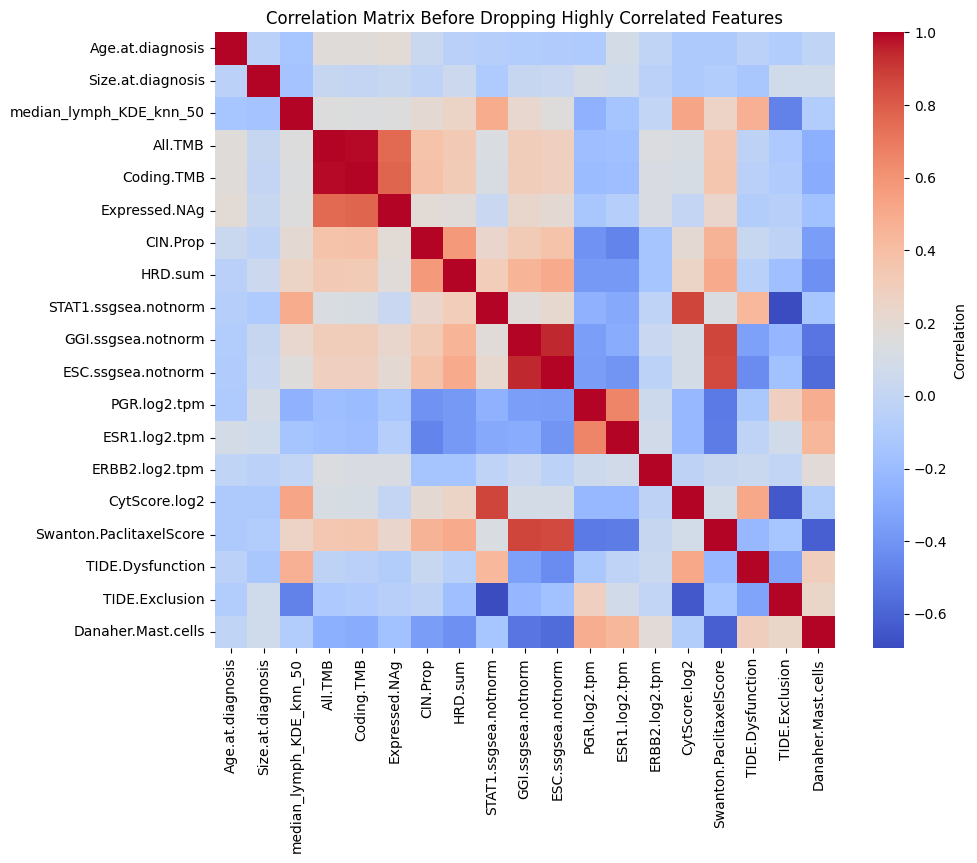

Variance Inflation Factors (VIF) Before Dropping Highly Correlated Features:
                    Feature        VIF
0          Age.at.diagnosis   1.270988
1         Size.at.diagnosis   1.129665
2   median_lymph_KDE_knn_50   2.008911
3                   All.TMB  62.133282
4                Coding.TMB  63.737975
5             Expressed.NAg   2.754725
6                  CIN.Prop   2.013994
7                   HRD.sum   1.988916
8      STAT1.ssgsea.notnorm   7.266043
9        GGI.ssgsea.notnorm  15.651135
10       ESC.ssgsea.notnorm  18.361314
11             PGR.log2.tpm   2.574445
12            ESR1.log2.tpm   2.950404
13           ERBB2.log2.tpm   1.198322
14            CytScore.log2   5.017676
15  Swanton.PaclitaxelScore   9.645721
16         TIDE.Dysfunction   3.634382
17           TIDE.Exclusion   3.105821
18       Danaher.Mast.cells   2.330938

Dropped Highly Correlated Features: {'CytScore.log2', 'Coding.TMB', 'ESC.ssgsea.notnorm', 'Swanton.PaclitaxelScore'}
DataFrame Shape after Rem

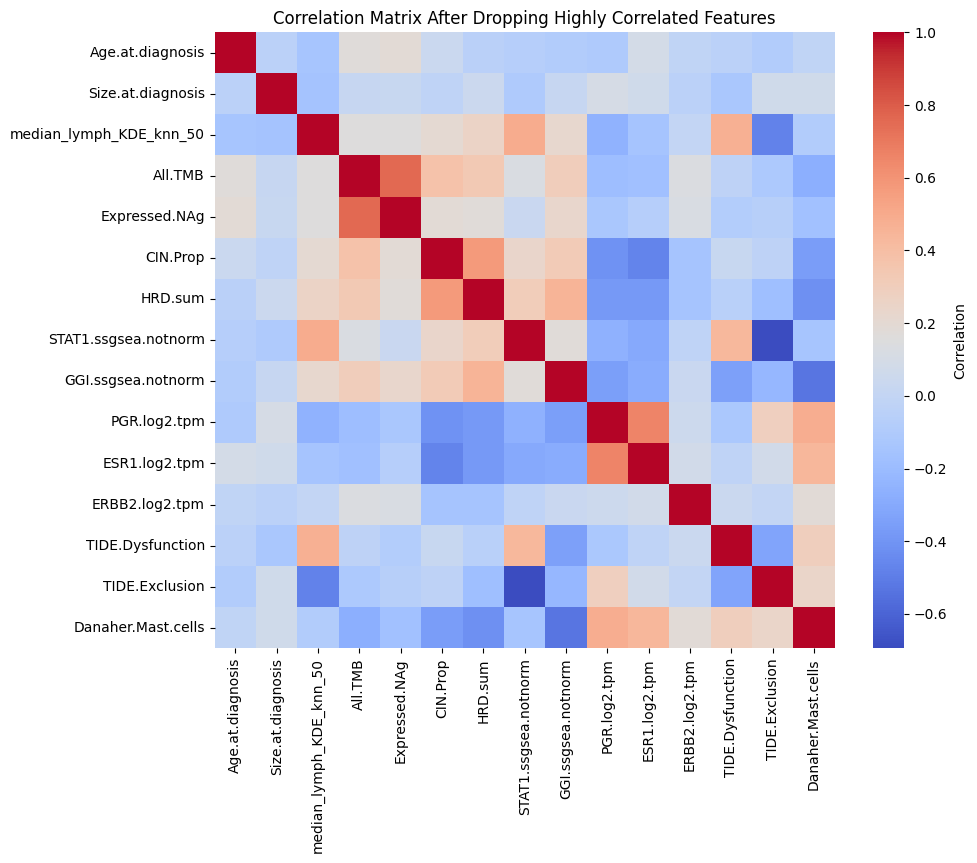


Variance Inflation Factors (VIF) After Dropping Highly Correlated Features:
                    Feature       VIF
0          Age.at.diagnosis  1.243006
1         Size.at.diagnosis  1.073155
2   median_lymph_KDE_knn_50  1.943723
3                   All.TMB  3.033399
4             Expressed.NAg  2.610690
5                  CIN.Prop  1.949088
6                   HRD.sum  1.897832
7      STAT1.ssgsea.notnorm  2.887368
8        GGI.ssgsea.notnorm  2.123055
9              PGR.log2.tpm  2.524443
10            ESR1.log2.tpm  2.411400
11           ERBB2.log2.tpm  1.155674
12         TIDE.Dysfunction  2.417036
13           TIDE.Exclusion  2.864437
14       Danaher.Mast.cells  2.148277


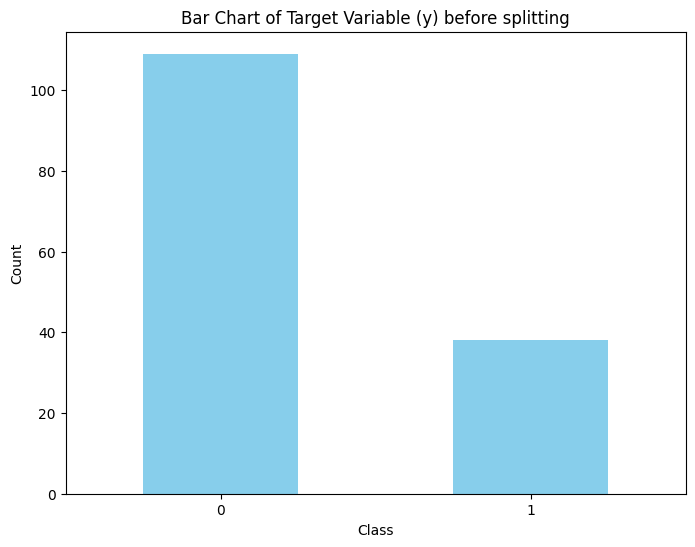

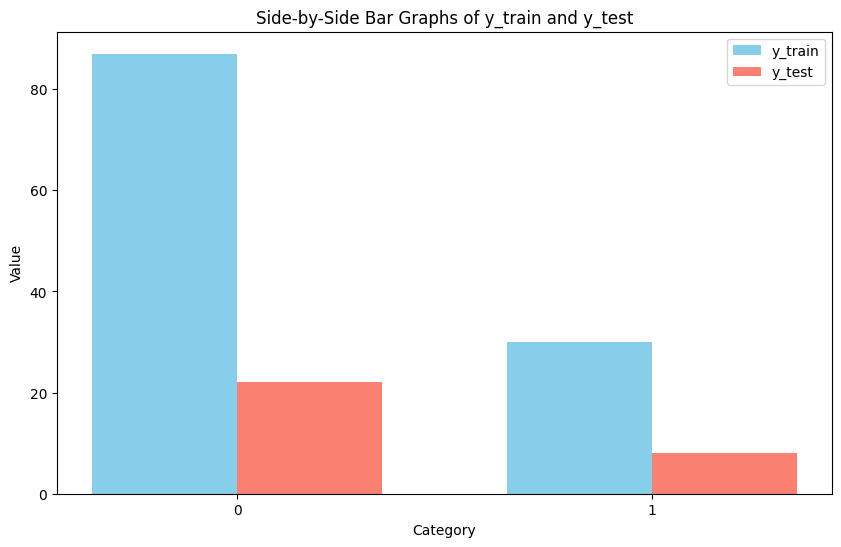

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.7, AUC-ROC: 0.6761363636363636, F1 Score: 0.5263157894736842, TPR: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.875 0.875 0.75  0.625 0.625 0.625 0.5   0.375 0.375
 0.375 0.25  0.25  0.125 0.125 0.    0.   ], FPR: [0.         0.04545455 0.04545455 0.09090909 0.09090909 0.13636364
 0.13636364 0.22727273 0.22727273 0.31818182 0.31818182 0.36363636
 0.36363636 1.        ], AUC-PR: 0.42522702991452993, MCC: 0.3232676249994279, Balanced Accuracy: 0.6761363636363636, Cohen's Kappa: 0.31472081218274106
Best parameters for Support Vector Machine: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.7, AUC-ROC: 0.5965909090909091, F1 Score: 0.39999999999999997, TPR: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.875 0.875 0.875 0.875 0.875 0.75  0.625 0.5   0.375
 0.25  0.25  0.25  0.25  0.125 0.    0.   

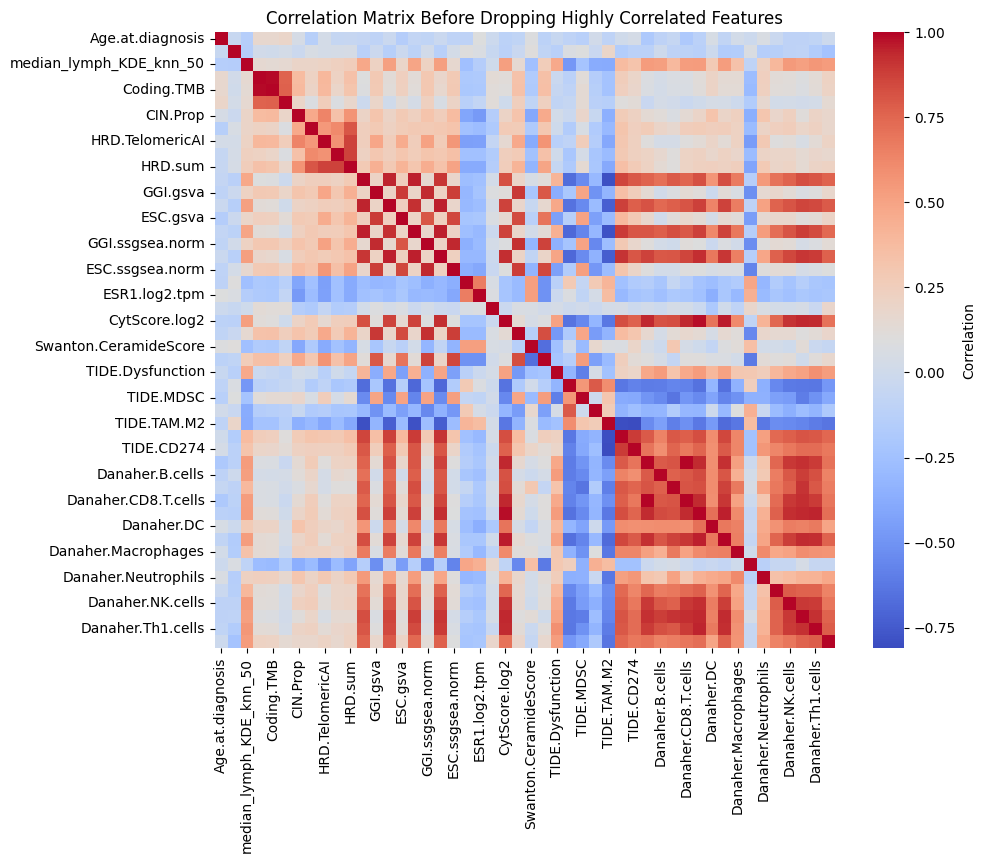

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors (VIF) Before Dropping Highly Correlated Features:
                     Feature           VIF
0           Age.at.diagnosis  1.814499e+00
1          Size.at.diagnosis  1.426911e+00
2    median_lymph_KDE_knn_50  2.857536e+00
3                    All.TMB  7.575509e+01
4                 Coding.TMB  7.452648e+01
5              Expressed.NAg  3.765994e+00
6                   CIN.Prop  2.839966e+00
7                    HRD.LOH  1.059671e+14
8            HRD.TelomericAI  1.324588e+14
9                    HRD.LST  1.125900e+14
10                   HRD.sum  5.629500e+14
11                STAT1.gsva  4.869026e+01
12                  GGI.gsva  2.243597e+01
13                  GEP.gsva  4.773828e+01
14                  ESC.gsva  1.798715e+01
15         STAT1.ssgsea.norm  1.059183e+02
16           GGI.ssgsea.norm  7.356564e+01
17           GEP.ssgsea.norm  1.462899e+02
18           ESC.ssgsea.norm  5.915023e+01
19              PGR.log2.tpm  3.919661e+00
20             ESR1.

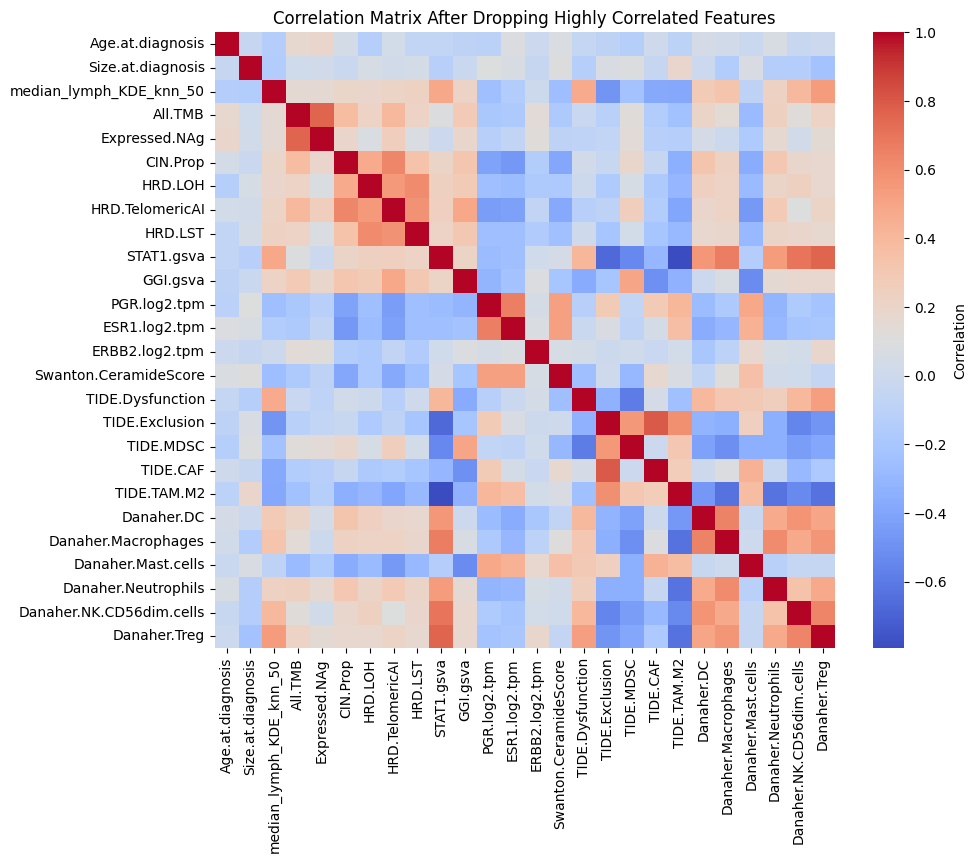


Variance Inflation Factors (VIF) After Dropping Highly Correlated Features:
                     Feature         VIF
0           Age.at.diagnosis    1.471644
1          Size.at.diagnosis    1.238048
2    median_lymph_KDE_knn_50    2.242411
3                    All.TMB    3.329283
4              Expressed.NAg    2.932400
5                   CIN.Prop    2.344147
6                    HRD.LOH    2.056913
7            HRD.TelomericAI    3.232890
8                    HRD.LST    2.060272
9                 STAT1.gsva    7.384112
10                  GGI.gsva    4.300195
11              PGR.log2.tpm    2.663741
12             ESR1.log2.tpm    3.246150
13            ERBB2.log2.tpm    1.455630
14     Swanton.CeramideScore    3.553763
15          TIDE.Dysfunction    4.966209
16            TIDE.Exclusion  756.188642
17                 TIDE.MDSC  189.591991
18                  TIDE.CAF  396.266190
19               TIDE.TAM.M2   57.408885
20                Danaher.DC    2.925256
21       Danaher.Macr

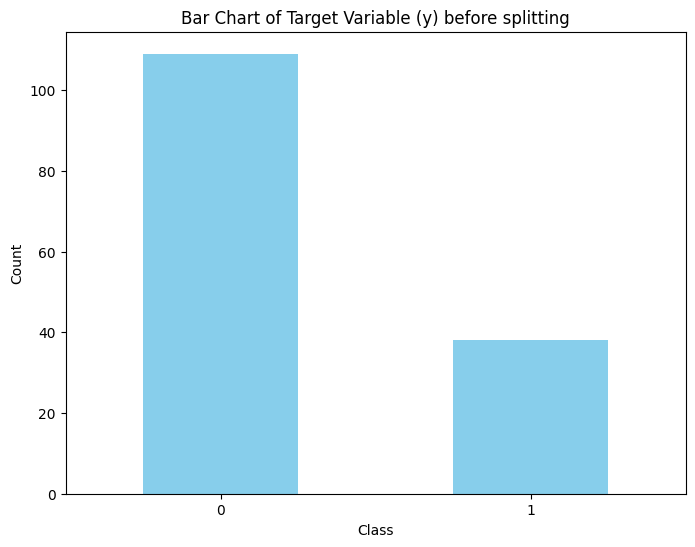

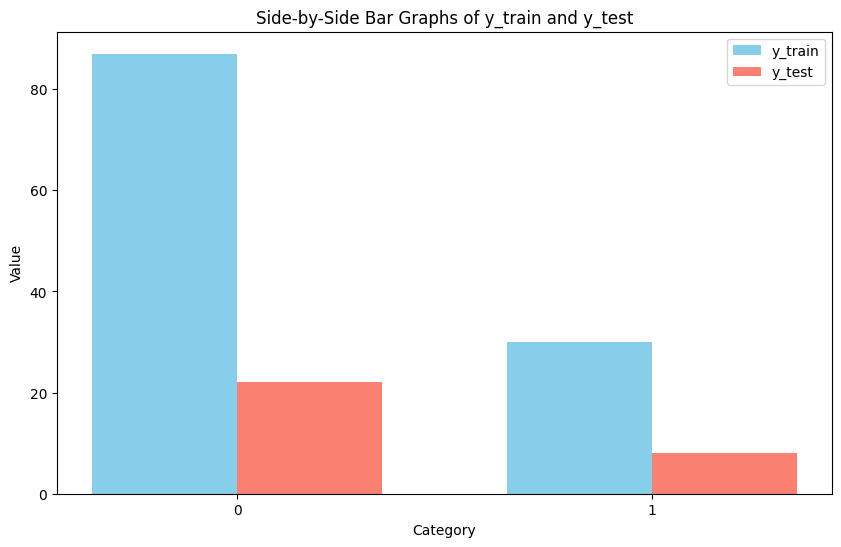

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.7333333333333333, AUC-ROC: 0.6988636363636364, F1 Score: 0.5555555555555556, TPR: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.875 0.75  0.625 0.625 0.625 0.625 0.625 0.5   0.375
 0.375 0.375 0.25  0.25  0.25  0.125 0.   ], FPR: [0.         0.         0.         0.09090909 0.09090909 0.18181818
 0.18181818 0.36363636 0.36363636 1.        ], AUC-PR: 0.6099511599511599, MCC: 0.3731012536223182, Balanced Accuracy: 0.6988636363636364, Cohen's Kappa: 0.36842105263157887
Best parameters for Support Vector Machine: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.8, AUC-ROC: 0.625, F1 Score: 0.4, TPR: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.875 0.875 0.875 0.75  0.75  0.625 0.5   0.375 0.25
 0.25  0.25  0.25  0.25  0.25  0.125 0.   ], FPR: [0.         0.         0.         0.22727273 0.22727273 0

In [ ]:
# train models
trained_model_results = model_training(t_df,partial_df,y)

In [ ]:
df_trained_results = trained_model_results.drop(['auc_roc_values','pr_values'],axis=1)

NameError: name 'trained_model_results' is not defined

In [ ]:
# draw table of evaluation matrices for all trained models
def pivot_and_display(df, groupby_columns, pivot_columns, caption='Pivoted Table', caption_color='blue', caption_font_size='16px', font_size='14px', text_align='center'):
    # Check if groupby_columns and pivot_columns exist in df
    if not set(groupby_columns + pivot_columns).issubset(df.columns):
        print("Error: Groupby or pivot columns not found in DataFrame.")
        return

    # Group by columns and then pivot the DataFrame
    try:
        pivot_df = df.groupby(groupby_columns).apply(lambda x: x.pivot_table(index=x.index, columns=groupby_columns + pivot_columns))
    except Exception as e:
        print(f"Error occurred during grouping and pivoting: {e}")
        return

    # Remove the multi-level index for columns
    pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]

    # Display the pivoted DataFrame
    styled_html = (pivot_df
                   .set_caption(caption)
                   .style.set_table_styles([{'selector': 'caption',
                                             'props': [('color', caption_color), ('font-size', caption_font_size)]}])
                   .set_properties(**{'font-size': font_size, 'text-align': text_align})
                   .hide_index()
                   .render())

    display(HTML(styled_html))

#execute
pivot_and_display(df_trained_results, ['dataset','model'], ['AUC-ROC', 'Accuracy', 'F1 Score','TPR', 'FPR', 'AUC-PR', 'MCC', 'Balanced Accuracy', 'Cohen\'s Kappa'])


AttributeError: 'Index' object has no attribute 'columns'

In [ ]:
# Plot curve

# Extract value saved from df
# Initialize an empty dictionary to store the combined values
def plot_auroc_pr(df,df_name):
    auc_roc_dict = {}

    # Loop through the rows and merge dictionaries
    for row in df['auc_roc_values']:
        auc_roc_dict = {**auc_roc_dict, **row}

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    for name, (fpr, tpr, roc_auc) in auc_roc_dict.items():
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve {df_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Initialize an empty dictionary to store the combined values
    pr_dict = {}

    # Loop through the rows and merge dictionaries
    for row in df['pr_values']:
        pr_dict = {**pr_dict, **row}

    # Plot Precision-Recall curves
    plt.figure(figsize=(10, 6))
    for name, (precision, recall, auc_pr) in pr_dict.items():
        plt.plot(recall, precision, label=f'{name} (AUC = {auc_pr:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve {df_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


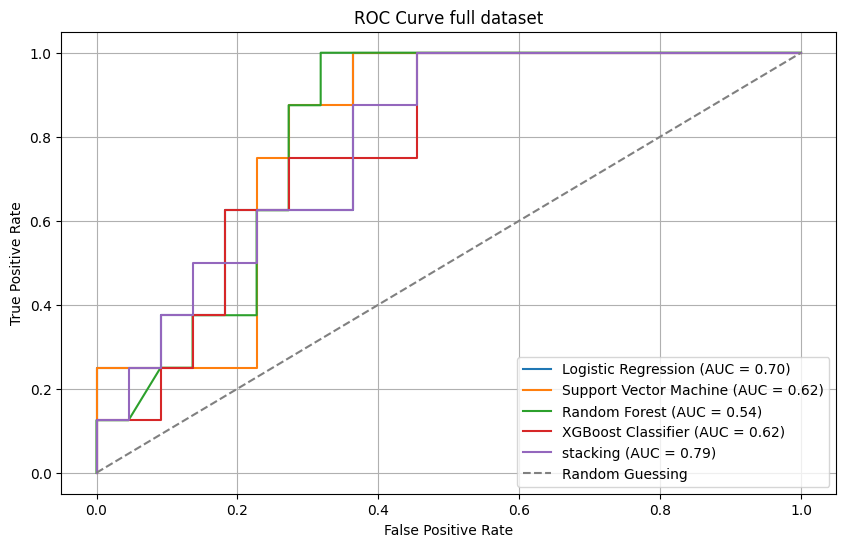

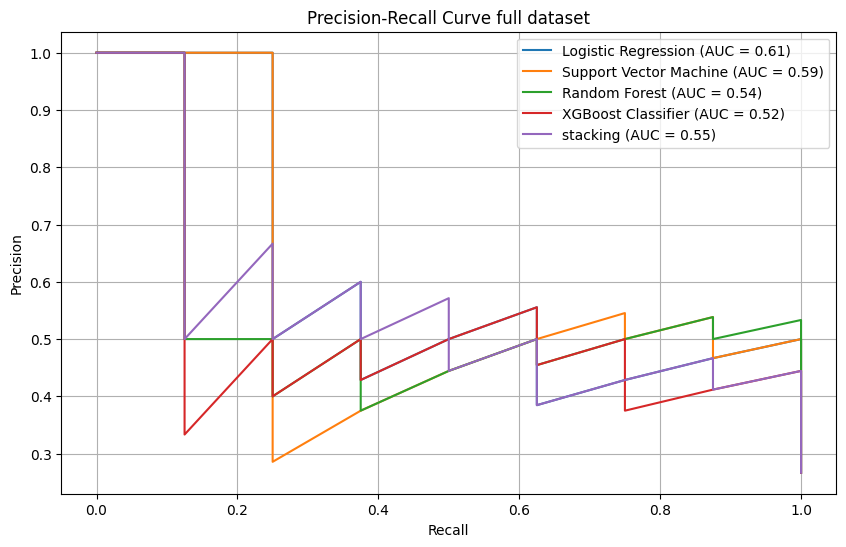

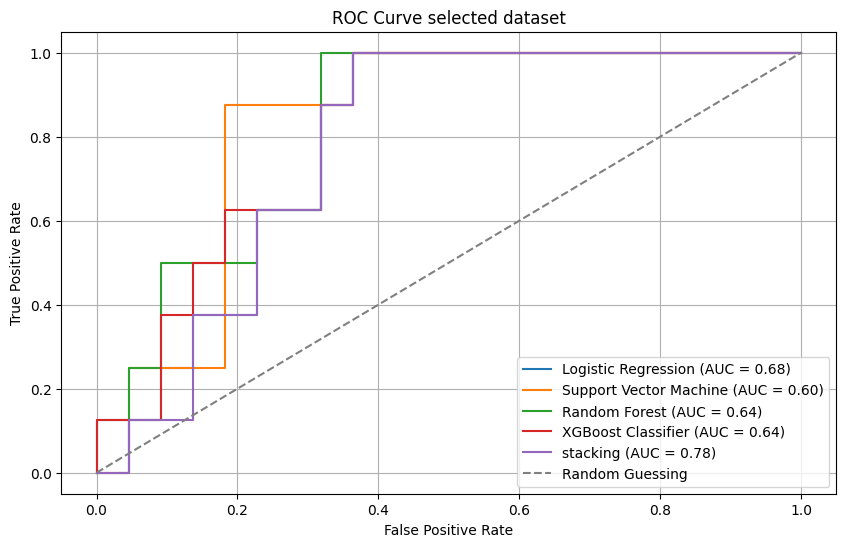

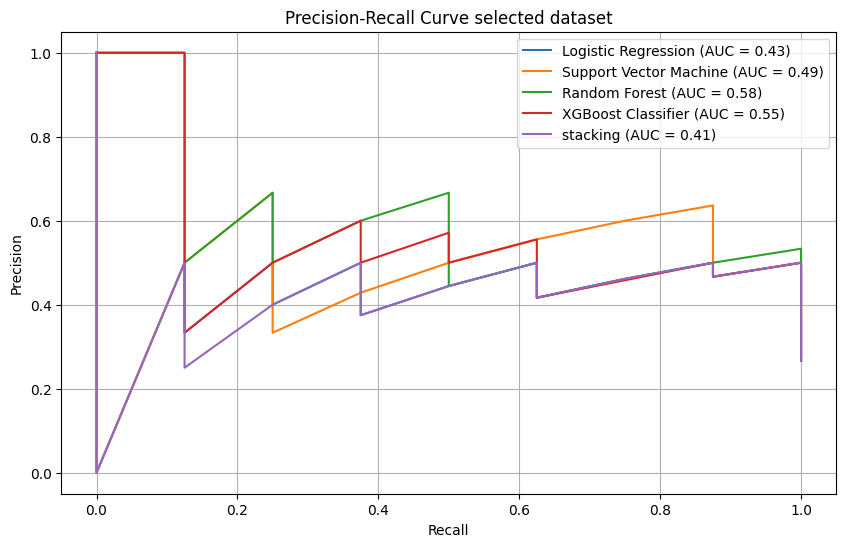

In [ ]:
def plot_2_df(df):
    # t_df results
    full_df = df[df['dataset'] == 'full_df']
    plot_auroc_pr(full_df,"full dataset")

    #st_df results
    partial_df = df[df['dataset'] == 'partial_df']
    plot_auroc_pr(partial_df,"selected dataset")

plot_2_df(trained_model_results)


In [ ]:
# Explore the effect of gradual exposure of model to training data
# use best model = stacking
# use feature importance from RF model previously announced

def train_and_evaluate_stacking_model_adj_f(X_train, X_test, y_train, y_test, feature_importance, class_weights=None, weights=None):
    # Define model
    name = "stacking"

    # Define the base learners
    base_learners = [
        ('lr', LogisticRegression(class_weight=weights, solver='newton-cg', random_state=0, penalty='l2')),
        ('xgb', XGBClassifier(n_estimators=2000, objective='binary:logistic', learning_rate=0.01,
                              use_label_encoder=False, eval_metric='logloss', random_state=0)),
        ('svc', SVC(probability=True, kernel='sigmoid', class_weight=weights, random_state=0))
    ]

    # Define the meta-learner
    meta_learner = LogisticRegression(class_weight=weights, solver='newton-cg', random_state=0, penalty='l2')

    # Initialize the Stacking Classifier with the correct number of classes
    stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5, stack_method='predict_proba', passthrough=False)

    # Model optimization
    results = []
    auc_scores = []

    feature_importance_list = feature_importance.iloc[:,0]

    max_features = len(feature_importance_list)  # Assuming feature_importance_list contains the feature importance values

    # Determine the increment size
    increment = max(1, int(max_features * 0.05))  # increment of 5% each iteration

    for num_features in range(1, max_features + 1, increment):  # Iterate over increasing numbers of top features
        top_features = feature_importance_list[:num_features]  # Get top 'num_features' features

        # Train model with top features
        X_train_subset = X_train[top_features]
        X_test_subset = X_test[top_features]

        # define param grid
        param_grid = {
        'final_estimator__C': [0.1, 1, 10],
        'final_estimator__penalty': ['l2']
        }

        # GridsearchCV
        grid_search = GridSearchCV(stacking_clf, param_grid, cv=5)
        grid_search.fit(X_train_subset, y_train)

        best_params = grid_search.best_params_

        stacking_clf = grid_search.best_estimator_
        stacking_clf.fit(X_train_subset, y_train)
        y_pred_proba = stacking_clf.predict_proba(X_test_subset)[:, 1]  # Probability of positive class
        y_pred = stacking_clf.predict(X_test_subset)  # Binary prediction

        # Get performance matrices
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        results.append({'num_features': num_features, 'params': best_params, 'accuracy': accuracy, 'roc_auc': roc_auc})
        auc_scores.append(roc_auc)

        print(f"Number of features: {num_features}, Best parameters: {best_params}, Accuracy: {accuracy}, AUC-ROC: {roc_auc}")

    # Create a DataFrame with the model results
    model_results_df = pd.DataFrame(results)

    # Plot AUC-ROC curve with annotated threshold
    plt.figure(figsize=(10, 6))
    plt.plot(model_results_df['num_features'], auc_scores, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('AUC-ROC Score')
    plt.ylim(0.5, 1.05)
    plt.title('AUC-ROC Score vs. Number of Features')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model_results_df, auc_scores



In [ ]:
# Train to see effect of increase features number on auc
# give df of all performance matrices
def model_training_adj_f(t_df,y):
  # train with t_df
  X_train_t, X_test_t, y_train_t, y_test_t, class_weights_t, weights_t = pipeline.fit_transform(t_df, y)
  # Normal model
  t_df_nr_model,auc_score = train_and_evaluate_stacking_model_adj_f(X_train_t, X_test_t, y_train_t, y_test_t,sorted_features, class_weights_t, weights_t)

  return t_df_nr_model

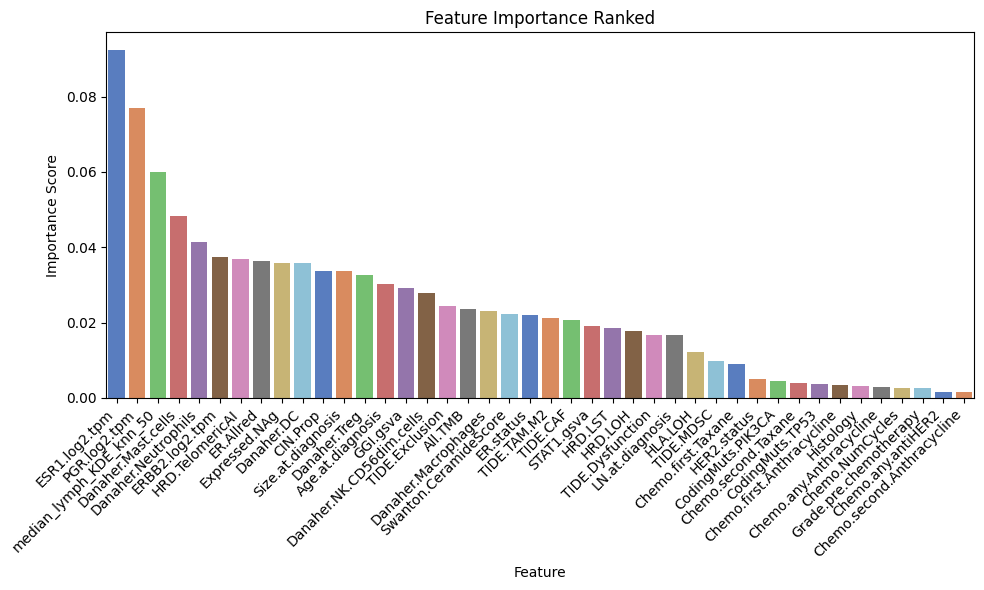

In [ ]:
# Plotting feature ranking
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=sorted_features, palette='muted', hue = 'Feature')  # Using 'rocket' palette for more colors
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance Ranked')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

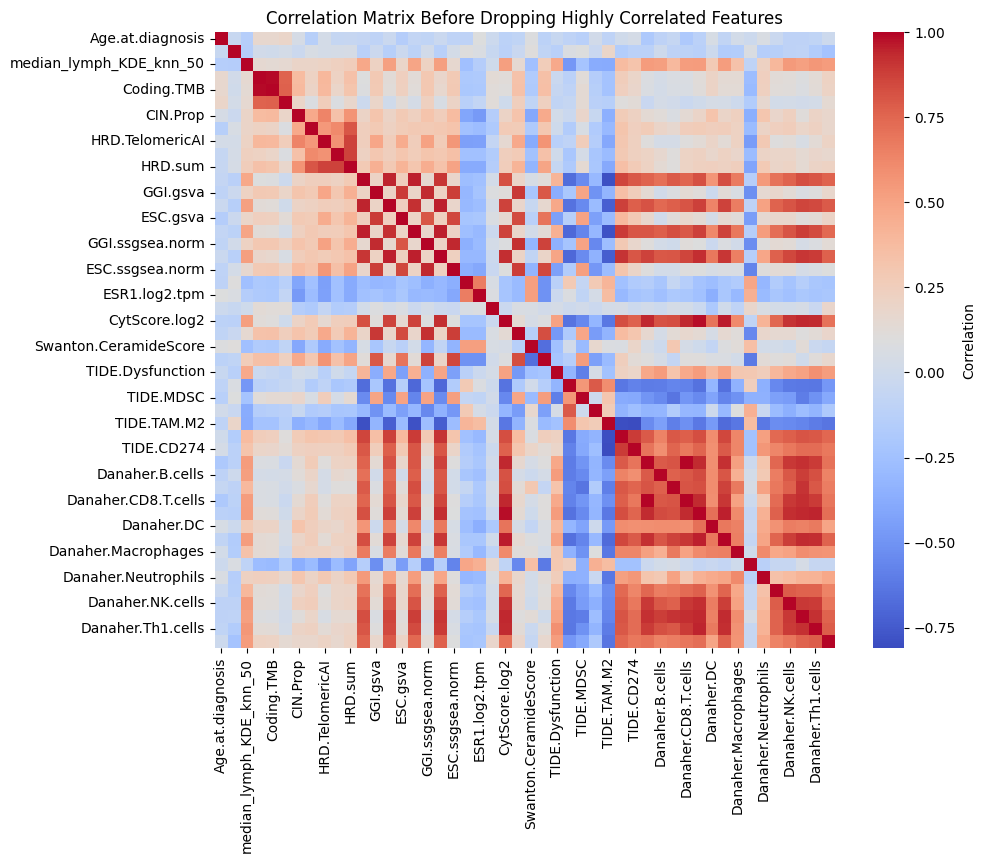

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors (VIF) Before Dropping Highly Correlated Features:
                     Feature           VIF
0           Age.at.diagnosis  1.814499e+00
1          Size.at.diagnosis  1.426911e+00
2    median_lymph_KDE_knn_50  2.857536e+00
3                    All.TMB  7.575509e+01
4                 Coding.TMB  7.452648e+01
5              Expressed.NAg  3.765994e+00
6                   CIN.Prop  2.839966e+00
7                    HRD.LOH  1.059671e+14
8            HRD.TelomericAI  1.324588e+14
9                    HRD.LST  1.125900e+14
10                   HRD.sum  5.629500e+14
11                STAT1.gsva  4.869026e+01
12                  GGI.gsva  2.243597e+01
13                  GEP.gsva  4.773828e+01
14                  ESC.gsva  1.798715e+01
15         STAT1.ssgsea.norm  1.059183e+02
16           GGI.ssgsea.norm  7.356564e+01
17           GEP.ssgsea.norm  1.462899e+02
18           ESC.ssgsea.norm  5.915023e+01
19              PGR.log2.tpm  3.919661e+00
20             ESR1.

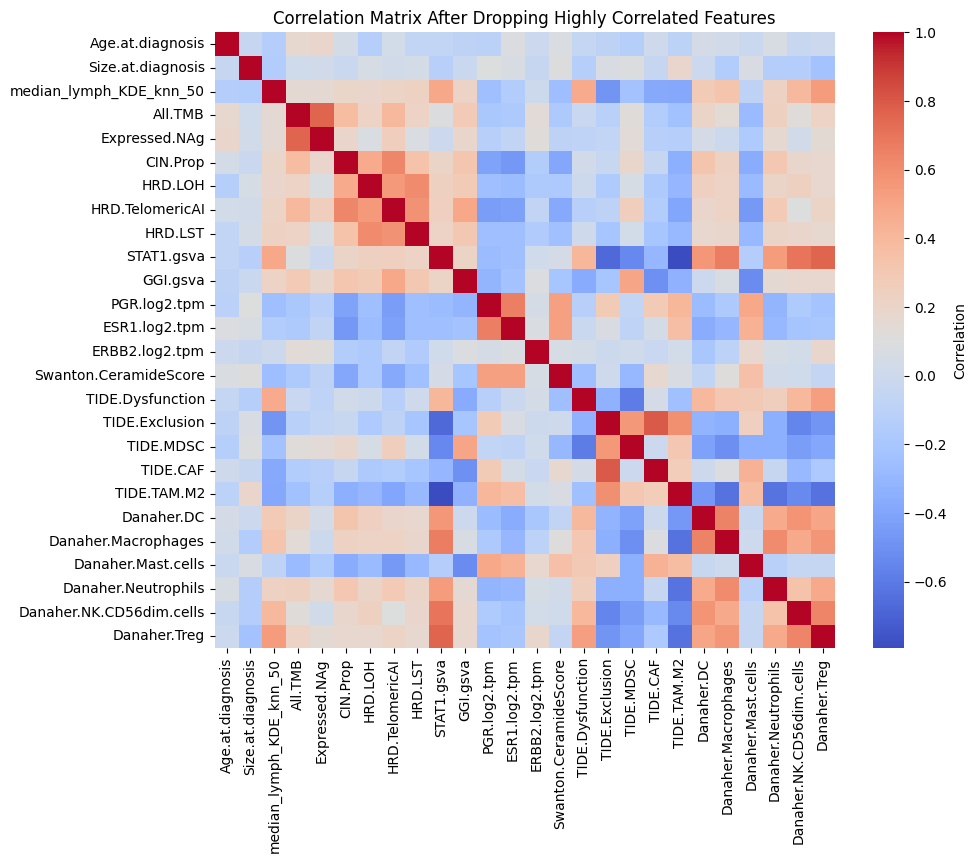


Variance Inflation Factors (VIF) After Dropping Highly Correlated Features:
                     Feature         VIF
0           Age.at.diagnosis    1.471644
1          Size.at.diagnosis    1.238048
2    median_lymph_KDE_knn_50    2.242411
3                    All.TMB    3.329283
4              Expressed.NAg    2.932400
5                   CIN.Prop    2.344147
6                    HRD.LOH    2.056913
7            HRD.TelomericAI    3.232890
8                    HRD.LST    2.060272
9                 STAT1.gsva    7.384112
10                  GGI.gsva    4.300195
11              PGR.log2.tpm    2.663741
12             ESR1.log2.tpm    3.246150
13            ERBB2.log2.tpm    1.455630
14     Swanton.CeramideScore    3.553763
15          TIDE.Dysfunction    4.966209
16            TIDE.Exclusion  756.188642
17                 TIDE.MDSC  189.591991
18                  TIDE.CAF  396.266190
19               TIDE.TAM.M2   57.408885
20                Danaher.DC    2.925256
21       Danaher.Macr

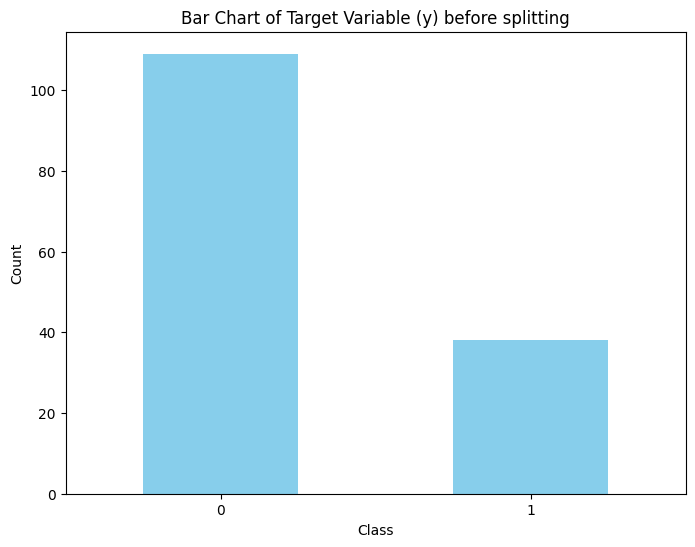

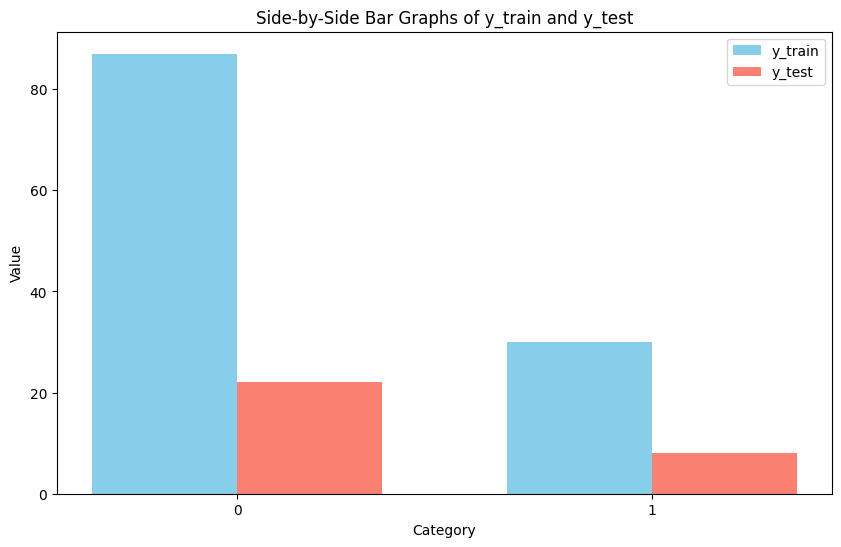

Number of features: 1, Best parameters: {'final_estimator__C': 10, 'final_estimator__penalty': 'l2'}, Accuracy: 0.7333333333333333, AUC-ROC: 0.7613636363636364
Number of features: 3, Best parameters: {'final_estimator__C': 1, 'final_estimator__penalty': 'l2'}, Accuracy: 0.7333333333333333, AUC-ROC: 0.8522727272727273
Number of features: 5, Best parameters: {'final_estimator__C': 10, 'final_estimator__penalty': 'l2'}, Accuracy: 0.7666666666666667, AUC-ROC: 0.8125
Number of features: 7, Best parameters: {'final_estimator__C': 10, 'final_estimator__penalty': 'l2'}, Accuracy: 0.7333333333333333, AUC-ROC: 0.8068181818181819
Number of features: 9, Best parameters: {'final_estimator__C': 1, 'final_estimator__penalty': 'l2'}, Accuracy: 0.7, AUC-ROC: 0.7784090909090909
Number of features: 11, Best parameters: {'final_estimator__C': 1, 'final_estimator__penalty': 'l2'}, Accuracy: 0.7, AUC-ROC: 0.7727272727272727
Number of features: 13, Best parameters: {'final_estimator__C': 0.1, 'final_estimato

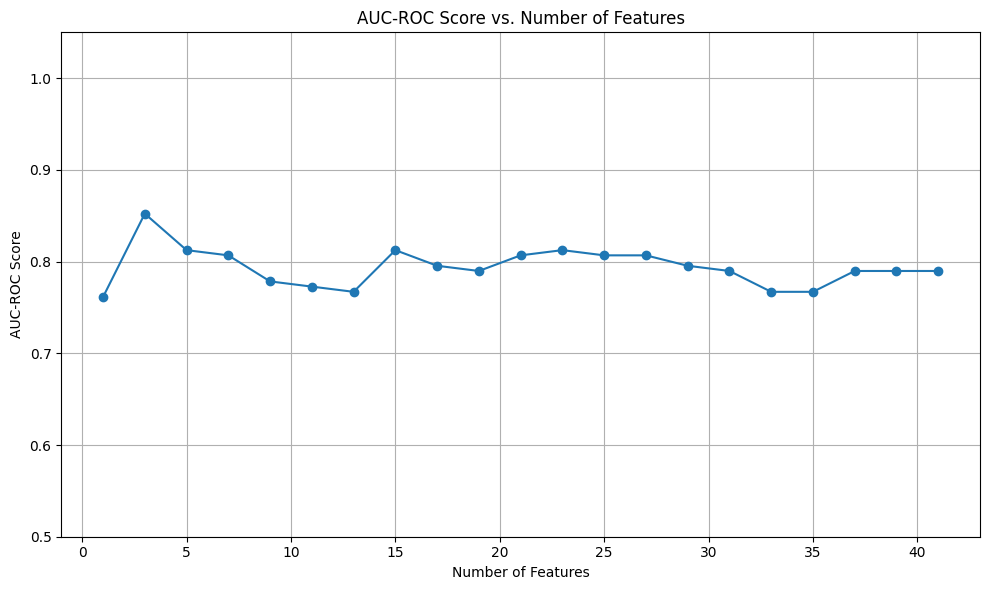

In [ ]:
# execute training with gradual exposure to data
adj_f_model_results = model_training_adj_f(t_df,y)

In [ ]:
# Train model with gradual increase in dataset size
# Plot learning curve

def train_and_evaluate_stacking_model_lr(X_train, X_test, y_train, y_test, feature_importance, class_weights=None, weights=None, num_features=None):
    # Define the base learners
    base_learners = [
        ('lr', LogisticRegression(class_weight=weights, solver='newton-cg', random_state=0, penalty='l2')),
        ('xgb', XGBClassifier(n_estimators=2000, objective='binary:logistic', learning_rate=0.01,
                               use_label_encoder=False, eval_metric='logloss', random_state=0)),
        ('svc', SVC(probability=True, kernel='sigmoid', class_weight=weights, random_state=0))
    ]

    # Define the meta-learner
    meta_learner = LogisticRegression(class_weight=weights, solver='newton-cg', random_state=0, penalty='l2')

    # Initialize lists to store results
    dataset_sizes = np.linspace(0.1, 1.0, 10)  # Vary dataset sizes from 10% to 100%
    results_train = []
    results_val = []

    # Set num_features if not input
    if num_features is None:
        num_features = len(X_train.columns)

    feature_importance_list = feature_importance.iloc[:, 0]
    selected_features = feature_importance_list[:num_features]  # Get top 'num_features' features

    # Train model with top features
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]

    for size in dataset_sizes:
        # Calculate the number of samples for the current size
        num_samples = int(len(X_train_subset) * size)

        # Cross-Validation Grid Search for Meta-Learner
        param_grid = {'C': [0.01, 0.1, 1, 10]}  # Adjust C values for regularization
        grid_search = GridSearchCV(meta_learner, param_grid, cv=5)
        grid_search.fit(X_train_subset, y_train)
        best_meta_params = grid_search.best_params_

        # Initialize the Stacking Classifier with the correct number of classes and tuned meta-learner
        stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner.set_params(**best_meta_params), cv=5,
                                           stack_method='predict_proba', passthrough=False)

        # Train the model on the current dataset size
        stacking_clf.fit(X_train_subset[:num_samples], y_train[:num_samples])

        # Evaluate performance on training set
        y_pred_proba_train = stacking_clf.predict_proba(X_train_subset[:num_samples])[:, 1]
        roc_auc_train = roc_auc_score(y_train[:num_samples], y_pred_proba_train)

        # Evaluate performance on validation set
        y_pred_proba_val = stacking_clf.predict_proba(X_test_subset)[:, 1]
        roc_auc_val = roc_auc_score(y_test, y_pred_proba_val)

        # Append results to the lists
        results_train.append({'dataset_size': size, 'roc_auc_train': roc_auc_train})
        results_val.append({'dataset_size': size, 'roc_auc_val': roc_auc_val})

    # Convert results to DataFrames for plotting
    results_train_df = pd.DataFrame(results_train)
    results_val_df = pd.DataFrame(results_val)

    # Plotting the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(results_train_df['dataset_size'], results_train_df['roc_auc_train'], label='AUC-ROC (Training)')
    plt.plot(results_val_df['dataset_size'], results_val_df['roc_auc_val'], label='AUC-ROC (Validation)')
    plt.xlabel('Training Dataset Size')
    plt.ylabel('AUC-ROC')
    plt.ylim(0.5, 1.05)
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results_train_df, results_val_df


In [ ]:
# Train for plot lr
# give df of all performance matrices


def model_training_lr(t_df,y):
  # from previous graph num of features with max auc roc = 17
  num_features_max_auroc = 17

  # train with t_df
  X_train_t, X_test_t, y_train_t, y_test_t, class_weights_t, weights_t = pipeline.fit_transform(t_df, y)
  # Normal model
  lr_train_results,lr_val_results = train_and_evaluate_stacking_model_lr(X_train_t, X_test_t, y_train_t, y_test_t,sorted_features, class_weights_t, weights_t,num_features=num_features_max_auroc)

  return lr_train_results,lr_val_results

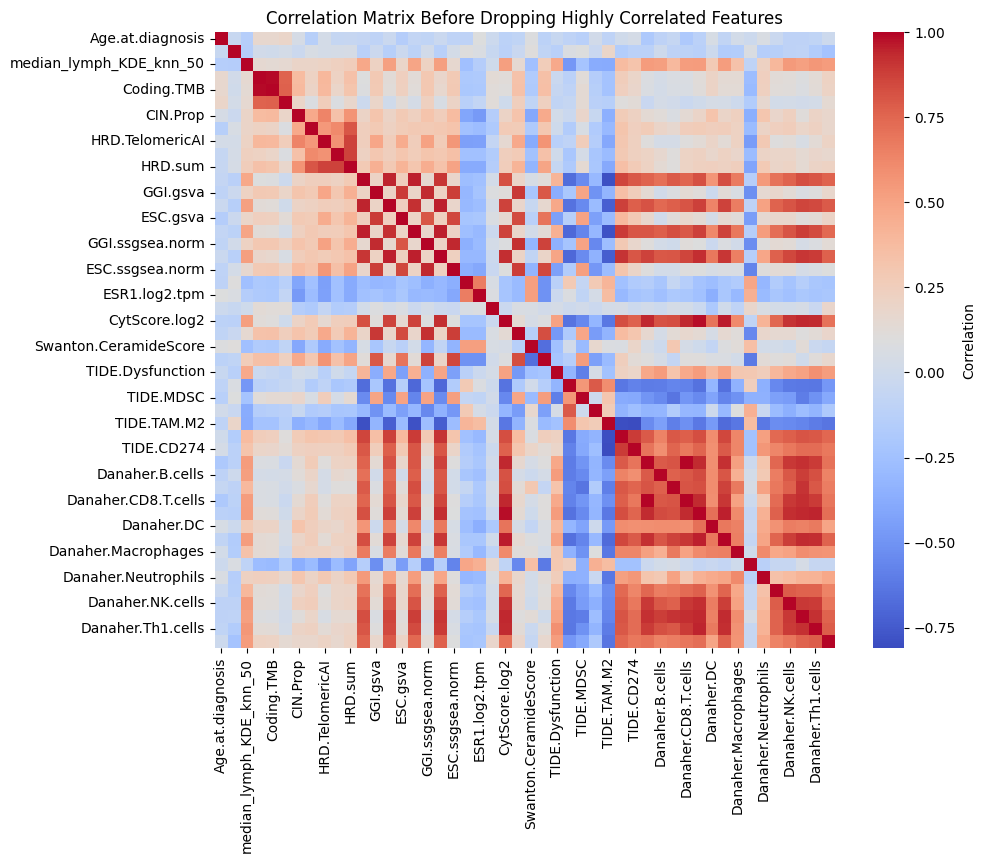

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors (VIF) Before Dropping Highly Correlated Features:
                     Feature           VIF
0           Age.at.diagnosis  1.814499e+00
1          Size.at.diagnosis  1.426911e+00
2    median_lymph_KDE_knn_50  2.857536e+00
3                    All.TMB  7.575509e+01
4                 Coding.TMB  7.452648e+01
5              Expressed.NAg  3.765994e+00
6                   CIN.Prop  2.839966e+00
7                    HRD.LOH  1.059671e+14
8            HRD.TelomericAI  1.324588e+14
9                    HRD.LST  1.125900e+14
10                   HRD.sum  5.629500e+14
11                STAT1.gsva  4.869026e+01
12                  GGI.gsva  2.243597e+01
13                  GEP.gsva  4.773828e+01
14                  ESC.gsva  1.798715e+01
15         STAT1.ssgsea.norm  1.059183e+02
16           GGI.ssgsea.norm  7.356564e+01
17           GEP.ssgsea.norm  1.462899e+02
18           ESC.ssgsea.norm  5.915023e+01
19              PGR.log2.tpm  3.919661e+00
20             ESR1.

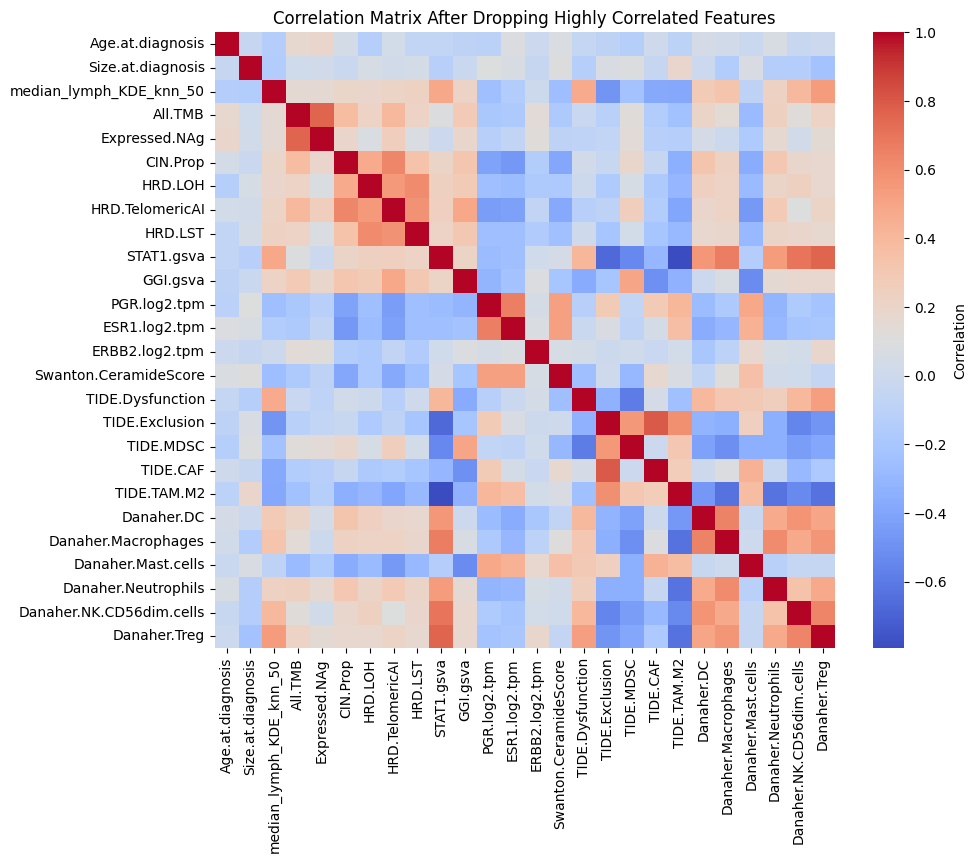


Variance Inflation Factors (VIF) After Dropping Highly Correlated Features:
                     Feature         VIF
0           Age.at.diagnosis    1.471644
1          Size.at.diagnosis    1.238048
2    median_lymph_KDE_knn_50    2.242411
3                    All.TMB    3.329283
4              Expressed.NAg    2.932400
5                   CIN.Prop    2.344147
6                    HRD.LOH    2.056913
7            HRD.TelomericAI    3.232890
8                    HRD.LST    2.060272
9                 STAT1.gsva    7.384112
10                  GGI.gsva    4.300195
11              PGR.log2.tpm    2.663741
12             ESR1.log2.tpm    3.246150
13            ERBB2.log2.tpm    1.455630
14     Swanton.CeramideScore    3.553763
15          TIDE.Dysfunction    4.966209
16            TIDE.Exclusion  756.188642
17                 TIDE.MDSC  189.591991
18                  TIDE.CAF  396.266190
19               TIDE.TAM.M2   57.408885
20                Danaher.DC    2.925256
21       Danaher.Macr

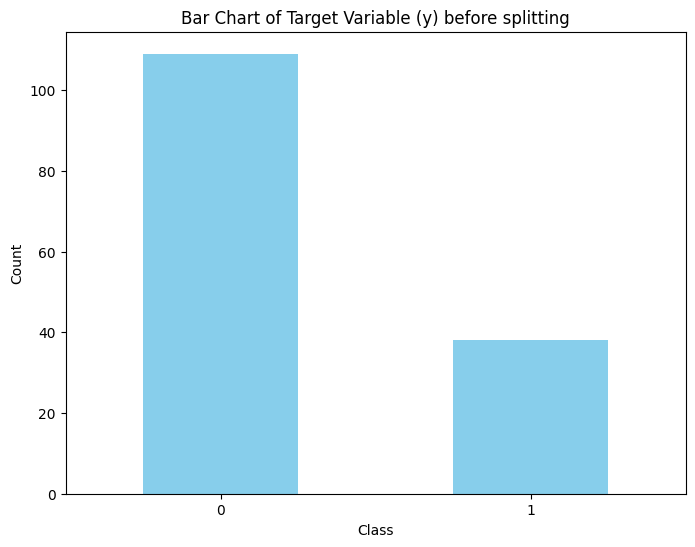

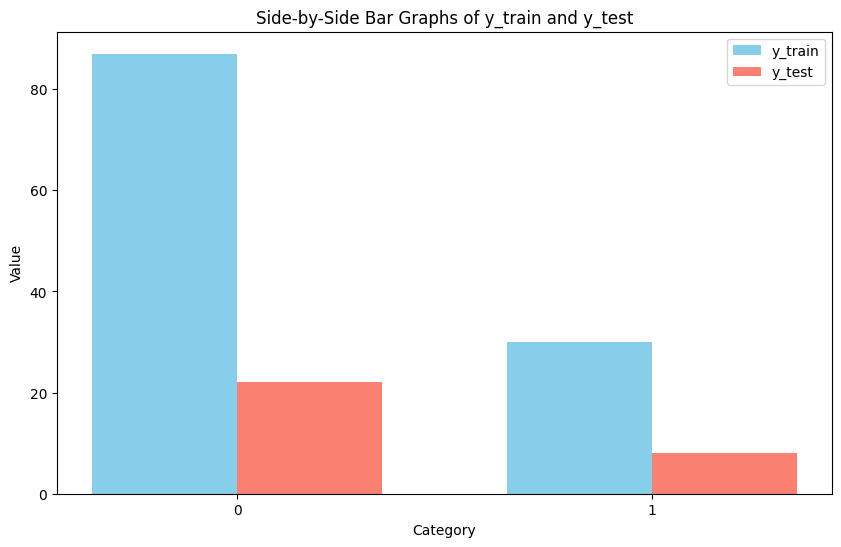

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


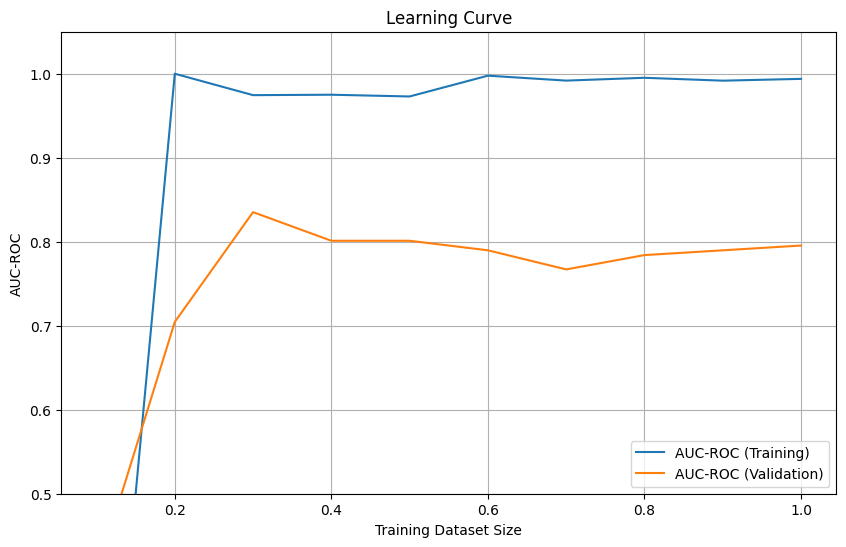

In [ ]:
lr_train_results,lr_val_results = model_training_lr(t_df,y)

In [ ]:
# model very overfitting
# lets try gridsearch for base learner as well

def train_and_evaluate_stacking_model_lr_mod(X_train, X_test, y_train, y_test, feature_importance, class_weights=None, weights=None, num_features=None):
    # Define the base learners with default hyperparameters
    base_learners = [
        ('lr', LogisticRegression(class_weight=weights, solver='newton-cg', random_state=0, penalty='l2')),
        ('xgb', XGBClassifier(n_estimators=2000, objective='binary:logistic', learning_rate=0.01,
                               use_label_encoder=False, eval_metric='logloss', random_state=0)),
        ('svc', SVC(probability=True, kernel='sigmoid', class_weight=weights, random_state=0))
    ]

    # Define the meta-learner
    meta_learner = LogisticRegression(class_weight=weights, solver='newton-cg', random_state=0, penalty='l2')

    # Define parameter grids for base learners
    param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
    param_grid_xgb = {'n_estimators': [100, 500, 1000], 'max_depth': [3, 5, 7]}
    param_grid_svc = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}

    # Initialize lists to store results
    dataset_sizes = np.linspace(0.1, 1.0, 10)  # Vary dataset sizes from 10% to 100%
    results_train = []
    results_val = []

    # Set num_features if not input
    if num_features is None:
        num_features = len(X_train.columns)

    feature_importance_list = feature_importance.iloc[:, 0]
    selected_features = feature_importance_list[:num_features]  # Get top 'num_features' features

    # Train model with top features
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]

    for size in dataset_sizes:
        # Calculate the number of samples for the current size
        num_samples = int(len(X_train_subset) * size)

        # Perform GridSearchCV for each base learner
        grid_search_lr = GridSearchCV(base_learners[0][1], param_grid_lr, cv=5)
        grid_search_xgb = GridSearchCV(base_learners[1][1], param_grid_xgb, cv=5)
        grid_search_svc = GridSearchCV(base_learners[2][1], param_grid_svc, cv=5)

        # Train the base learners with grid search
        grid_search_lr.fit(X_train_subset[:num_samples], y_train[:num_samples])
        grid_search_xgb.fit(X_train_subset[:num_samples], y_train[:num_samples])
        grid_search_svc.fit(X_train_subset[:num_samples], y_train[:num_samples])

        # Get the best estimators from grid search
        best_lr = grid_search_lr.best_estimator_
        best_xgb = grid_search_xgb.best_estimator_
        best_svc = grid_search_svc.best_estimator_

        # Update the base learners with best estimators
        base_learners = [
            ('lr', best_lr),
            ('xgb', best_xgb),
            ('svc', best_svc)
        ]

        # Cross-Validation Grid Search for Meta-Learner
        param_grid = {'C': [0.01, 0.1, 1, 10]}  # Adjust C values for regularization
        grid_search = GridSearchCV(meta_learner, param_grid, cv=5)
        grid_search.fit(X_train_subset, y_train)
        best_meta_params = grid_search.best_params_

        # Initialize the Stacking Classifier with the correct number of classes and tuned meta-learner
        stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner.set_params(**best_meta_params), cv=5,
                                           stack_method='predict_proba', passthrough=False)

        # Train the stacking model with tuned base learners
        stacking_clf.fit(X_train_subset[:num_samples], y_train[:num_samples])

        # Evaluate performance on training set
        y_pred_proba_train = stacking_clf.predict_proba(X_train_subset[:num_samples])[:, 1]
        roc_auc_train = roc_auc_score(y_train[:num_samples], y_pred_proba_train)

        # Evaluate performance on validation set
        y_pred_proba_val = stacking_clf.predict_proba(X_test_subset)[:, 1]
        roc_auc_val = roc_auc_score(y_test, y_pred_proba_val)

        # Append results to the lists
        results_train.append({'dataset_size': size, 'roc_auc_train': roc_auc_train})
        results_val.append({'dataset_size': size, 'roc_auc_val': roc_auc_val})

    # Convert results to DataFrames for plotting
    results_train_df = pd.DataFrame(results_train)
    results_val_df = pd.DataFrame(results_val)

    # Plotting the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(results_train_df['dataset_size'], results_train_df['roc_auc_train'], label='AUC-ROC (Training)')
    plt.plot(results_val_df['dataset_size'], results_val_df['roc_auc_val'], label='AUC-ROC (Validation)')
    plt.xlabel('Training Dataset Size')
    plt.ylabel('AUC-ROC')
    plt.ylim(0.5, 1.05)
    plt.title(f'Learning Curve with {num_features} features')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results_train_df, results_val_df



In [ ]:
# mod lr plot
# give df of all performance matrices
# model very over fitting, lets compare with lower number of features

def model_training_lr_mod(t_df,y):

  # train with t_df
  X_train_t, X_test_t, y_train_t, y_test_t, class_weights_t, weights_t = pipeline.fit_transform(t_df, y)
  train_and_evaluate_stacking_model_lr_mod(X_train_t, X_test_t, y_train_t, y_test_t,sorted_features, class_weights_t, weights_t,num_features=17)
  train_and_evaluate_stacking_model_lr_mod(X_train_t, X_test_t, y_train_t, y_test_t,sorted_features, class_weights_t, weights_t,num_features=10)
  train_and_evaluate_stacking_model_lr_mod(X_train_t, X_test_t, y_train_t, y_test_t,sorted_features, class_weights_t, weights_t,num_features=5)
  train_and_evaluate_stacking_model_lr_mod(X_train_t, X_test_t, y_train_t, y_test_t,sorted_features, class_weights_t, weights_t,num_features=1)



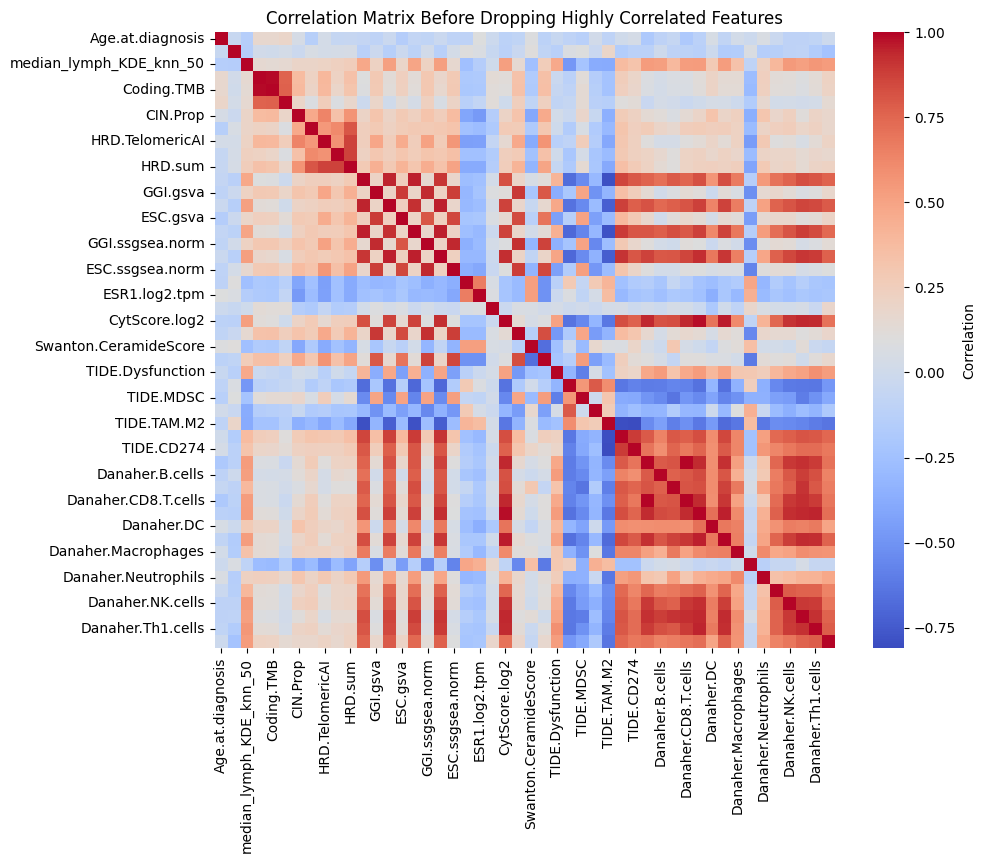

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors (VIF) Before Dropping Highly Correlated Features:
                     Feature           VIF
0           Age.at.diagnosis  1.814499e+00
1          Size.at.diagnosis  1.426911e+00
2    median_lymph_KDE_knn_50  2.857536e+00
3                    All.TMB  7.575509e+01
4                 Coding.TMB  7.452648e+01
5              Expressed.NAg  3.765994e+00
6                   CIN.Prop  2.839966e+00
7                    HRD.LOH  1.059671e+14
8            HRD.TelomericAI  1.324588e+14
9                    HRD.LST  1.125900e+14
10                   HRD.sum  5.629500e+14
11                STAT1.gsva  4.869026e+01
12                  GGI.gsva  2.243597e+01
13                  GEP.gsva  4.773828e+01
14                  ESC.gsva  1.798715e+01
15         STAT1.ssgsea.norm  1.059183e+02
16           GGI.ssgsea.norm  7.356564e+01
17           GEP.ssgsea.norm  1.462899e+02
18           ESC.ssgsea.norm  5.915023e+01
19              PGR.log2.tpm  3.919661e+00
20             ESR1.

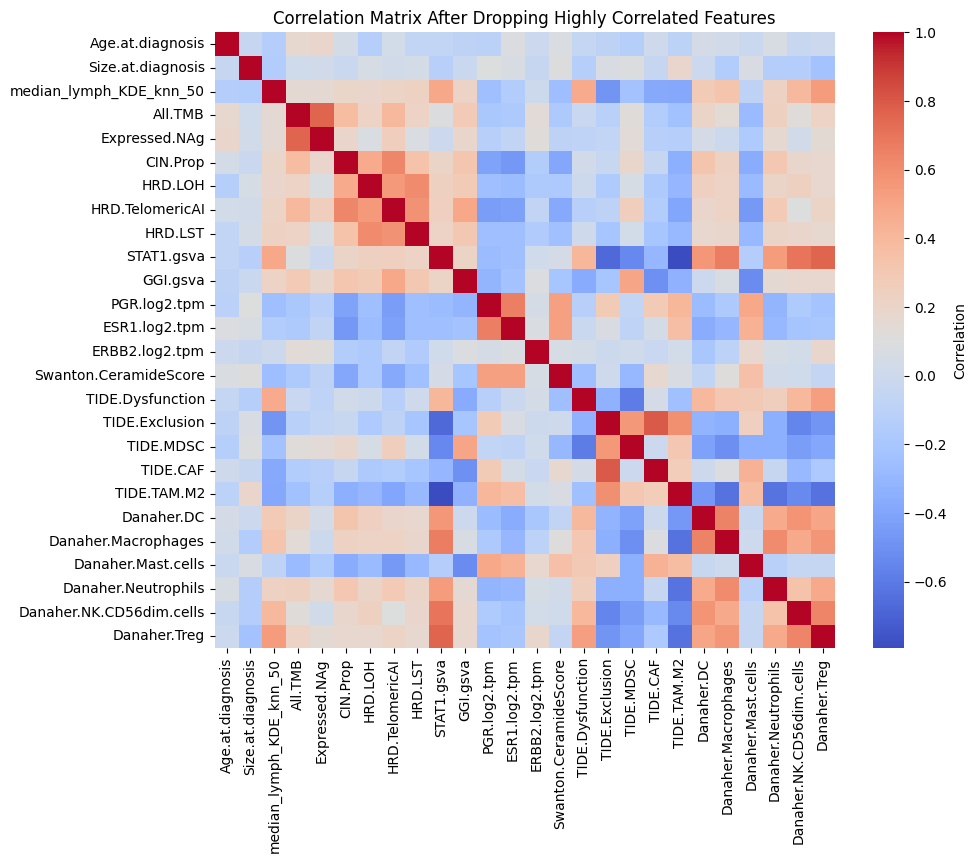


Variance Inflation Factors (VIF) After Dropping Highly Correlated Features:
                     Feature         VIF
0           Age.at.diagnosis    1.471644
1          Size.at.diagnosis    1.238048
2    median_lymph_KDE_knn_50    2.242411
3                    All.TMB    3.329283
4              Expressed.NAg    2.932400
5                   CIN.Prop    2.344147
6                    HRD.LOH    2.056913
7            HRD.TelomericAI    3.232890
8                    HRD.LST    2.060272
9                 STAT1.gsva    7.384112
10                  GGI.gsva    4.300195
11              PGR.log2.tpm    2.663741
12             ESR1.log2.tpm    3.246150
13            ERBB2.log2.tpm    1.455630
14     Swanton.CeramideScore    3.553763
15          TIDE.Dysfunction    4.966209
16            TIDE.Exclusion  756.188642
17                 TIDE.MDSC  189.591991
18                  TIDE.CAF  396.266190
19               TIDE.TAM.M2   57.408885
20                Danaher.DC    2.925256
21       Danaher.Macr

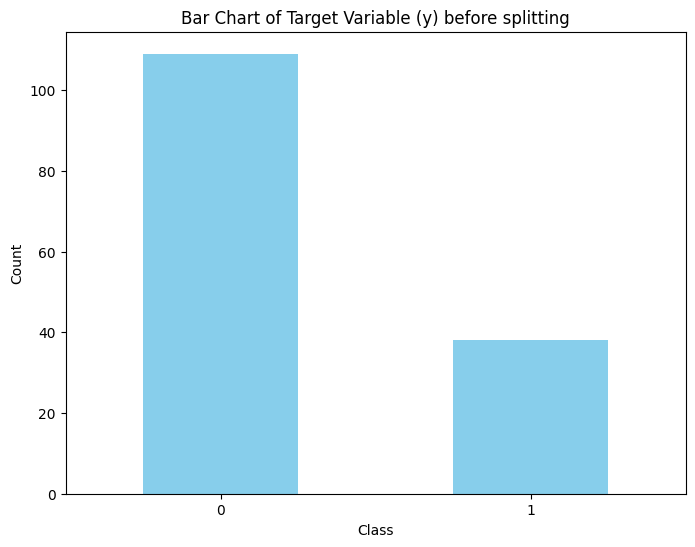

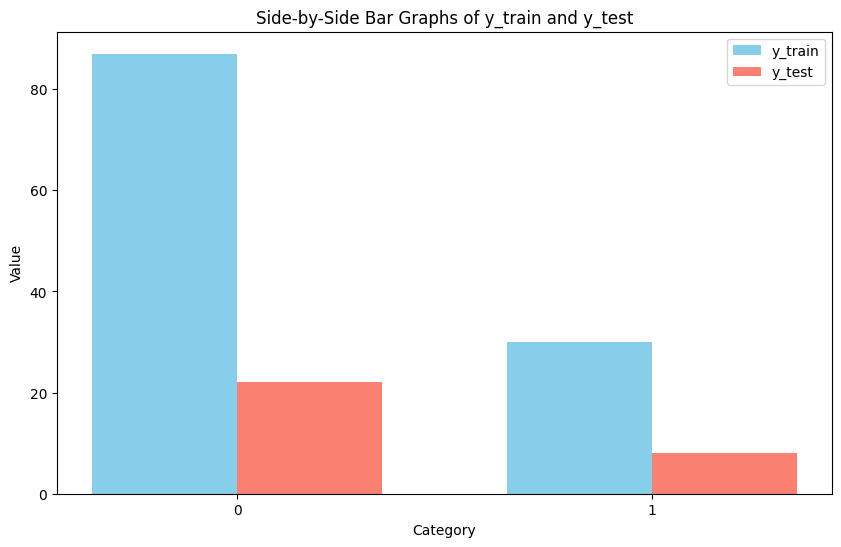

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

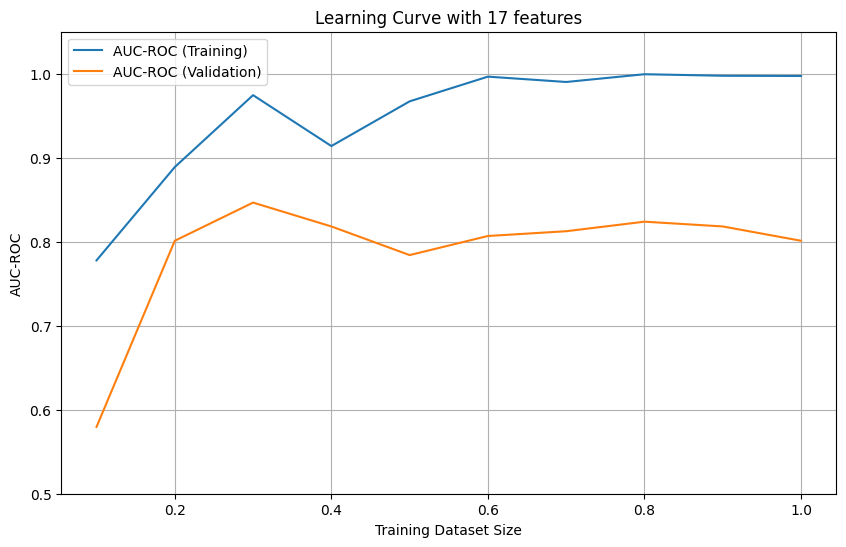

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

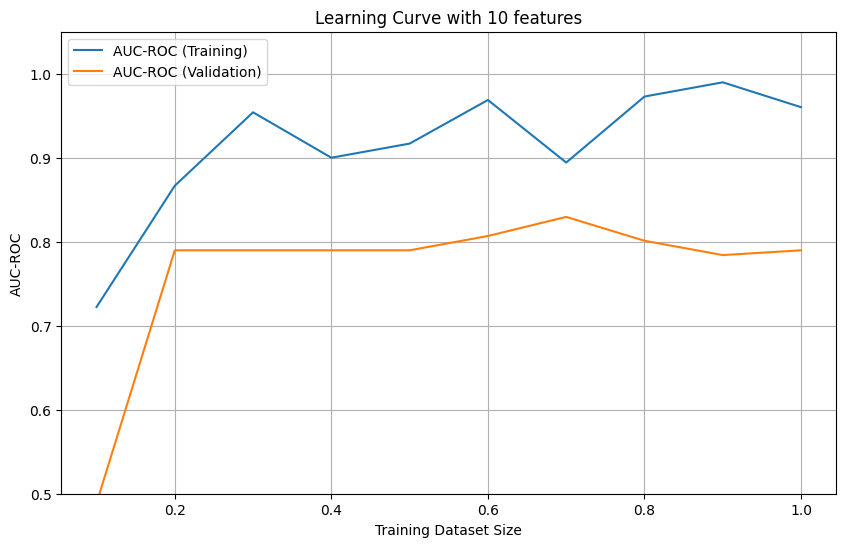

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

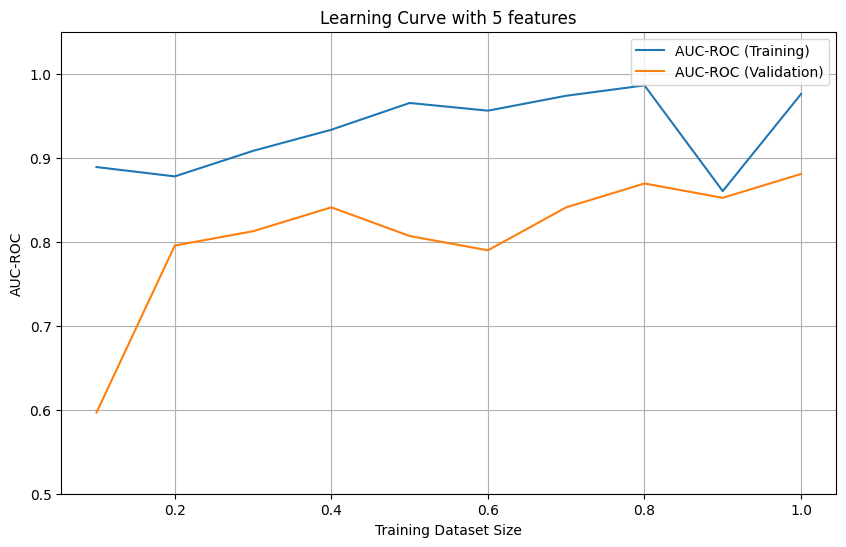

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

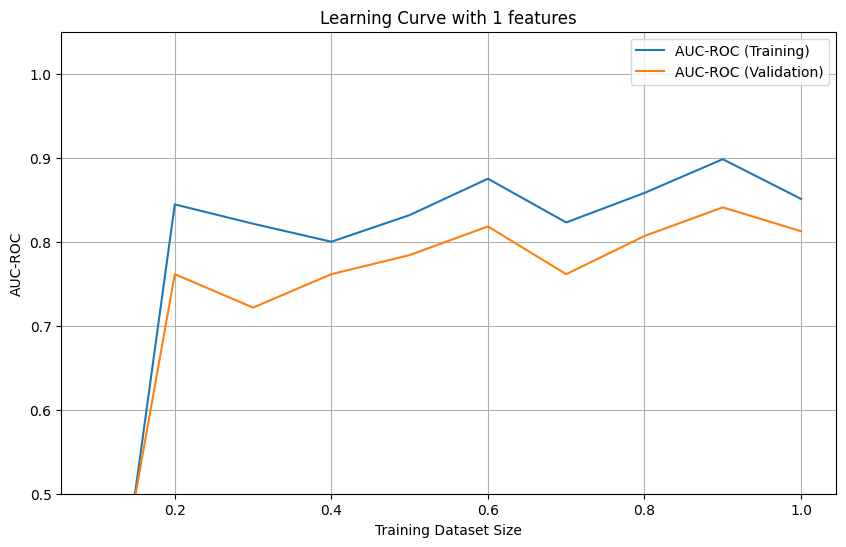

In [ ]:
model_training_lr_mod(t_df,y)

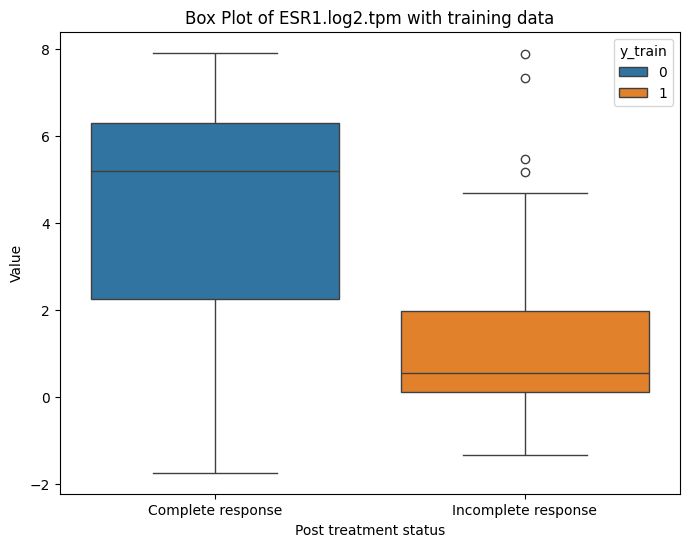

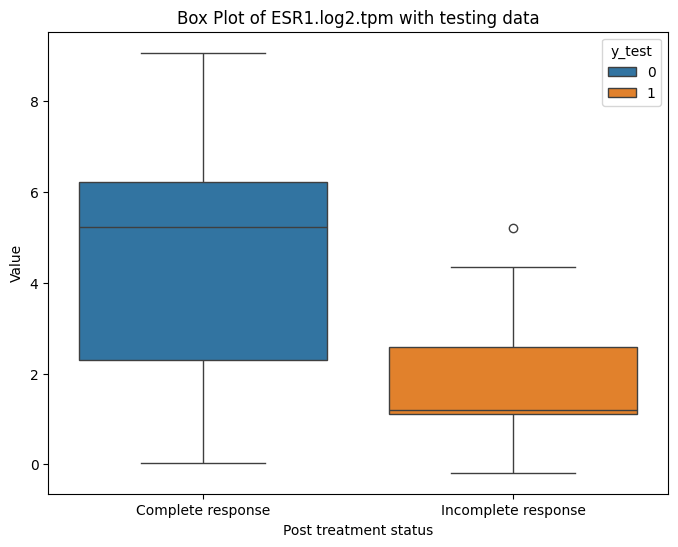

LR best parameter : LogisticRegression(C=0.01, class_weight={0: 0.6724137931034483, 1: 1.95},
                   random_state=0, solver='liblinear')


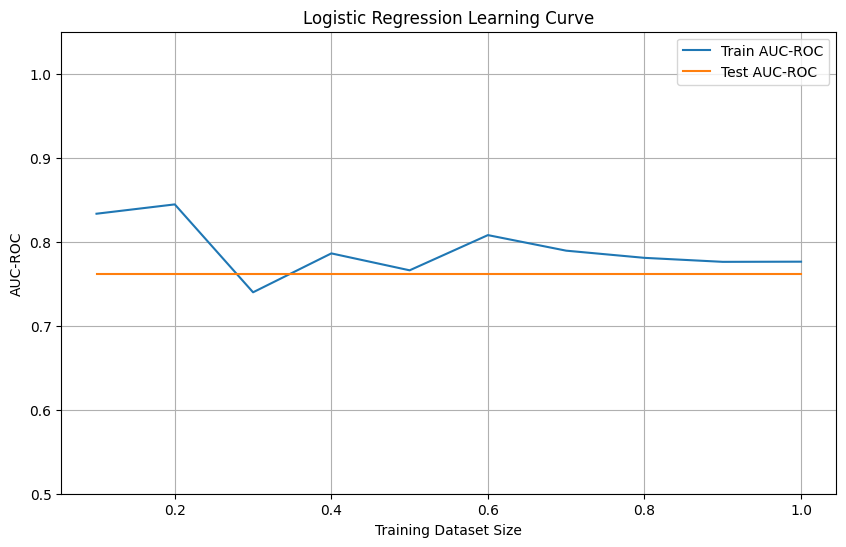

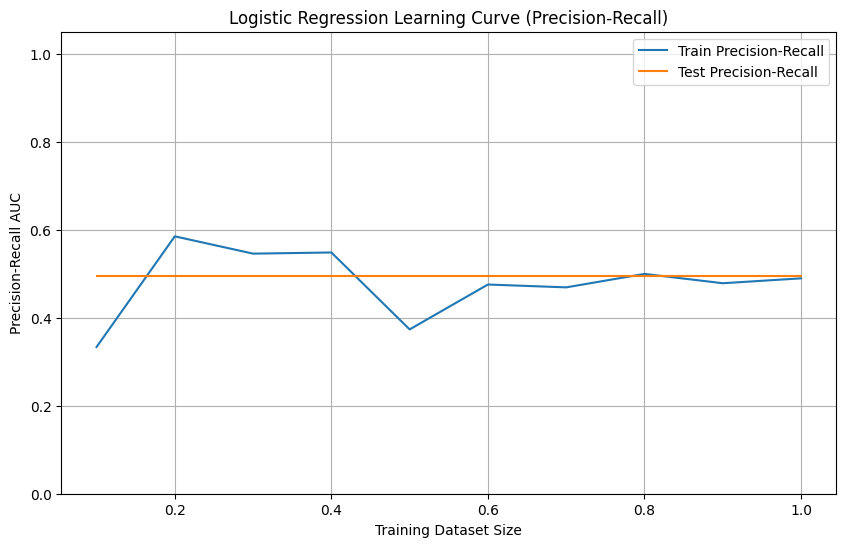

In [ ]:
# Stacking model with only 1 feature seems very promising
# lets go back to the basic
# LR showed best AUC previously
# lets train it with only 1 top feature and look at its learning rate

def back_to_basic(X, y, feature_importance):

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    weights = {i: class_weights[i] for i in np.unique(y_train)}

    # Select top feature
    feature_importance_list = feature_importance.iloc[:, 0]
    selected_features = feature_importance_list[:1]  # Get features

    # Train model with top features
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]

    # Visualize data distribution
    # Create a dictionary with lists as values and column names as keys
    data_dict_train = {'X_train_subset': X_train_subset.values.flatten(), 'y_train': y_train}
    data_dict_test = {'X_test_subset': X_test_subset.values.flatten(), 'y_test': y_test}

    # Convert the dictionary to a DataFrame
    df_plot_train = pd.DataFrame(data_dict_train)
    df_plot_test = pd.DataFrame(data_dict_test)

    # Plotting a box plot Training data
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='y_train', y='X_train_subset', data=df_plot_train, hue='y_train')
    plt.title(f'Box Plot of {selected_features.item()} with training data')
    plt.xticks([0, 1], ['Complete response', 'Incomplete response'])
    plt.xlabel('Post treatment status')
    plt.ylabel('Value')
    plt.show()

    # Plotting a box plot testing data
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='y_test', y='X_test_subset', data=df_plot_test, hue='y_test')
    plt.title(f'Box Plot of {selected_features.item()} with testing data')
    plt.xticks([0, 1], ['Complete response', 'Incomplete response'])
    plt.xlabel('Post treatment status')
    plt.ylabel('Value')
    plt.show()

    # Initialize a logistic regression model
    lr_model = LogisticRegression(class_weight=weights, random_state=0)

    # Define hyperparameters to search over
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga']
    }

    # Perform GridSearchCV for hyperparameter optimization
    grid_search = GridSearchCV(lr_model, param_grid, cv=5)
    grid_search.fit(X_train_subset, y_train)

    # Get the best model from GridSearchCV
    best_lr_model = grid_search.best_estimator_

    print("LR best parameter :",best_lr_model)

    # Initialize lists to store results
    train_auc_roc_scores = []
    test_auc_roc_scores = []
    train_precision_scores = []
    test_precision_scores = []

    # Vary training dataset size from 10% to 100%
    dataset_sizes = np.linspace(0.1, 1.0, 10)

    # Train the model with different dataset sizes
    for size in dataset_sizes:
        num_samples = int(len(X_train) * size)
        X_train_subsubset, y_train_subset = X_train_subset[:num_samples], y_train[:num_samples]

        # Fit the model
        best_lr_model.fit(X_train_subsubset, y_train_subset)

        # Predict probabilities for training and test sets
        y_train_pred_proba = best_lr_model.predict_proba(X_train_subsubset)[:, 1]
        y_test_pred_proba = best_lr_model.predict_proba(X_test_subset)[:, 1]

        # Calculate AUC-ROC scores
        train_auc = roc_auc_score(y_train_subset, y_train_pred_proba)
        test_auc = roc_auc_score(y_test, y_test_pred_proba)

        # Append AUC-ROC scores to the lists
        train_auc_roc_scores.append(train_auc)
        test_auc_roc_scores.append(test_auc)

        # Calculate precision-recall scores
        train_precision, train_recall, _ = precision_recall_curve(y_train_subset, y_train_pred_proba)
        test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_pred_proba)

        # Calculate AUC-PR scores
        train_auc_pr = auc(train_recall, train_precision)
        test_auc_pr = auc(test_recall, test_precision)

        # Append AUC-PR scores to the lists
        train_precision_scores.append(train_auc_pr)
        test_precision_scores.append(test_auc_pr)

    # Plotting the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(dataset_sizes, train_auc_roc_scores, label='Train AUC-ROC')
    plt.plot(dataset_sizes, test_auc_roc_scores, label='Test AUC-ROC')
    plt.xlabel('Training Dataset Size')
    plt.ylabel('AUC-ROC')
    plt.title('Logistic Regression Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.ylim(0.5, 1.05)  # Set y-axis limits if desired
    plt.show()

    # Plotting the learning curve for precision-recall
    plt.figure(figsize=(10, 6))
    plt.plot(dataset_sizes, train_precision_scores, label='Train Precision-Recall')
    plt.plot(dataset_sizes, test_precision_scores, label='Test Precision-Recall')
    plt.xlabel('Training Dataset Size')
    plt.ylabel('Precision-Recall AUC')
    plt.title('Logistic Regression Learning Curve (Precision-Recall)')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05)  # Set y-axis limits between 0 and 1 for Precision-Recall AUC
    plt.show()

    return best_lr_model

# execute
best_model = back_to_basic(t_df, y, sorted_features)



In [ ]:
# What is wrong with the top feature?
# lets plot box plot
top_f = sorted_features.iloc[:, 0][:1].item()

# Plotting a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='resp.pCR', y=top_f, data=df_total,hue='resp.pCR')
plt.title(f'Box Plot of {top_f} by Category')
plt.xticks([0, 1], ['Complete response', 'Incomplete response'])
plt.xlabel('Post treatment status')
plt.ylabel(top_f)
plt.show()

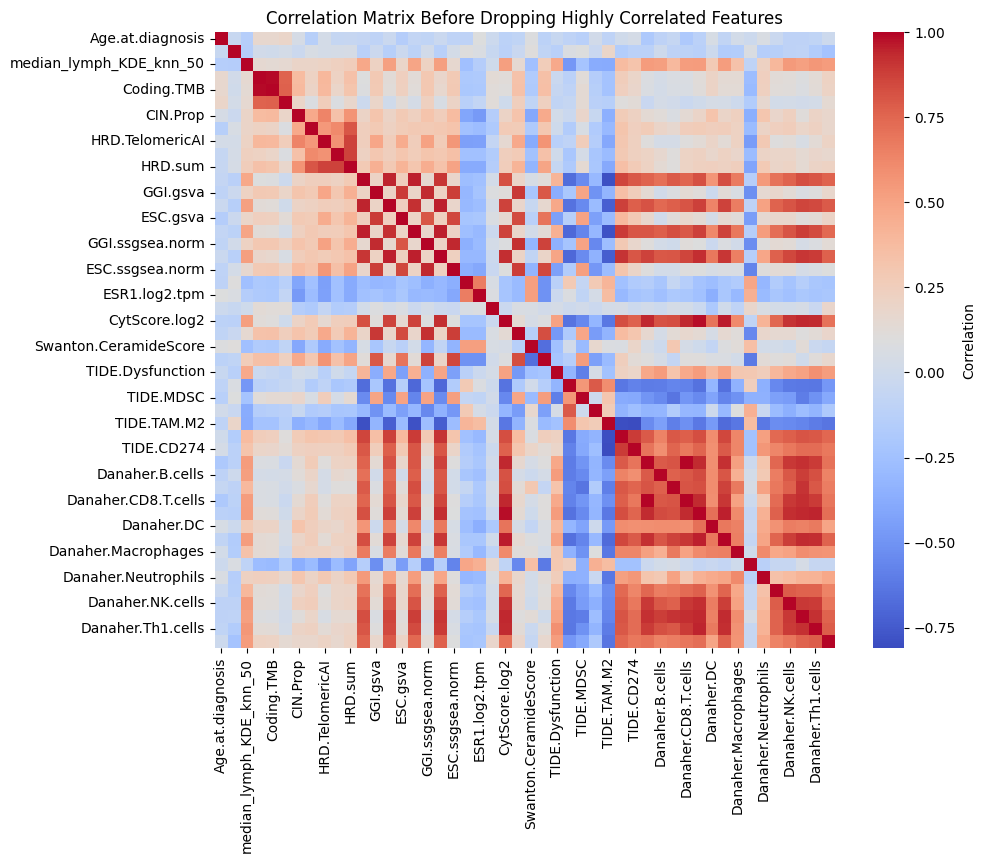

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors (VIF) Before Dropping Highly Correlated Features:
                     Feature           VIF
0           Age.at.diagnosis  1.814499e+00
1          Size.at.diagnosis  1.426911e+00
2    median_lymph_KDE_knn_50  2.857536e+00
3                    All.TMB  7.575509e+01
4                 Coding.TMB  7.452648e+01
5              Expressed.NAg  3.765994e+00
6                   CIN.Prop  2.839966e+00
7                    HRD.LOH  1.059671e+14
8            HRD.TelomericAI  1.324588e+14
9                    HRD.LST  1.125900e+14
10                   HRD.sum  5.629500e+14
11                STAT1.gsva  4.869026e+01
12                  GGI.gsva  2.243597e+01
13                  GEP.gsva  4.773828e+01
14                  ESC.gsva  1.798715e+01
15         STAT1.ssgsea.norm  1.059183e+02
16           GGI.ssgsea.norm  7.356564e+01
17           GEP.ssgsea.norm  1.462899e+02
18           ESC.ssgsea.norm  5.915023e+01
19              PGR.log2.tpm  3.919661e+00
20             ESR1.

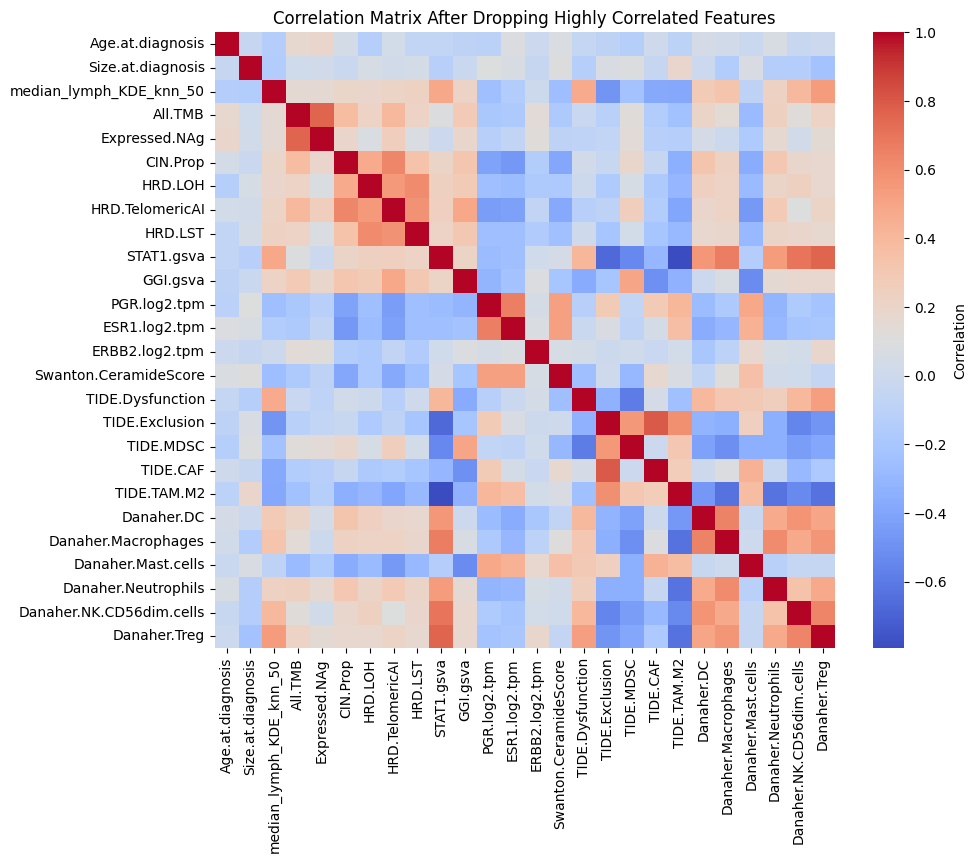


Variance Inflation Factors (VIF) After Dropping Highly Correlated Features:
                     Feature         VIF
0           Age.at.diagnosis    1.471644
1          Size.at.diagnosis    1.238048
2    median_lymph_KDE_knn_50    2.242411
3                    All.TMB    3.329283
4              Expressed.NAg    2.932400
5                   CIN.Prop    2.344147
6                    HRD.LOH    2.056913
7            HRD.TelomericAI    3.232890
8                    HRD.LST    2.060272
9                 STAT1.gsva    7.384112
10                  GGI.gsva    4.300195
11              PGR.log2.tpm    2.663741
12             ESR1.log2.tpm    3.246150
13            ERBB2.log2.tpm    1.455630
14     Swanton.CeramideScore    3.553763
15          TIDE.Dysfunction    4.966209
16            TIDE.Exclusion  756.188642
17                 TIDE.MDSC  189.591991
18                  TIDE.CAF  396.266190
19               TIDE.TAM.M2   57.408885
20                Danaher.DC    2.925256
21       Danaher.Macr

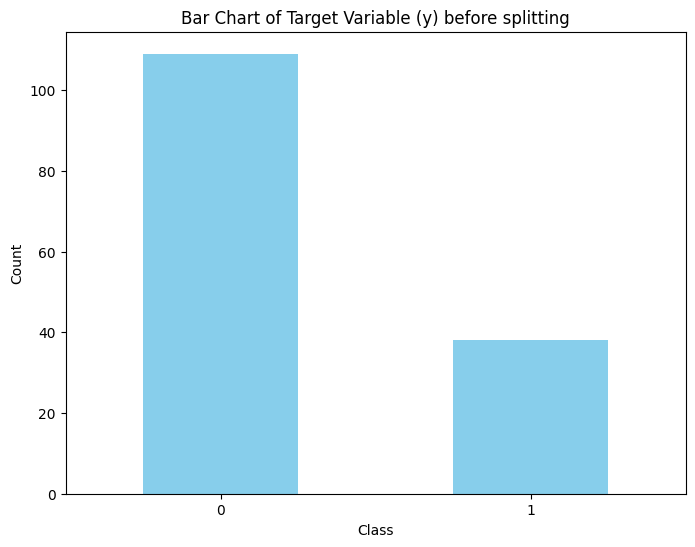

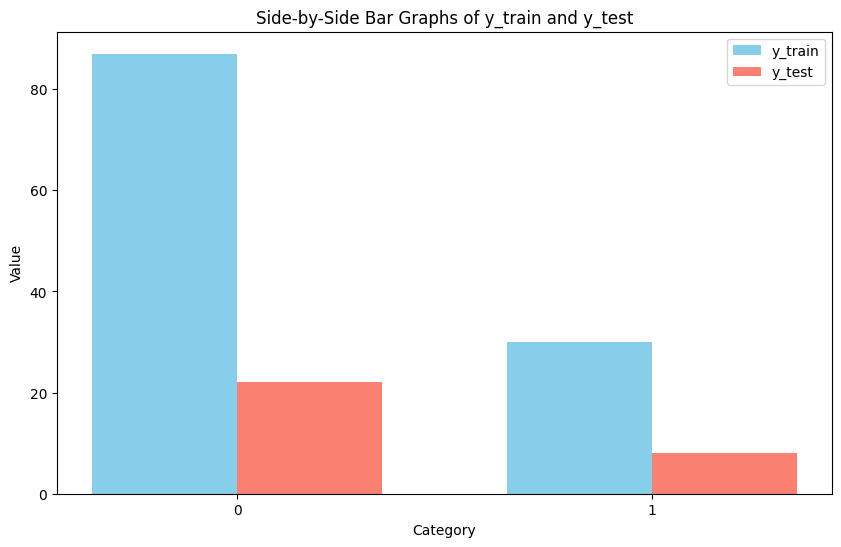

y_train
resp.pCR
0    9
1    2
Name: count, dtype: int64
y_test
resp.pCR
0    22
1     8
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR best parameter : LogisticRegression(C=0.001, class_weight={0: 0.6724137931034483, 1: 1.95},
                   random_state=0, solver='newton-cg')
y_train
resp.pCR
0    18
1     5
Name: count, dtype: int64
y_test
resp.pCR
0    22
1     8
Name: count, dtype: int64
LR best parameter : LogisticRegression(C=0.001, class_weight={0: 0.6724137931034483, 1: 1.95},
                   random_state=0, solver='newton-cg')
y_train
resp.pCR
0    28
1     7
Name: count, dtype: int64
y_test
resp.pCR
0    22
1     8
Name: count, dtype: int64
LR best parameter : LogisticRegression(C=0.001, class_weight={0: 0.6724137931034483, 1: 1.95},
                   random_state=0, solver='newton-cg')
y_train
resp.pCR
0    36
1    10
Name: count, dtype: int64
y_test
resp.pCR
0    22
1     8
Name: count, dtype: int64
LR best parameter : LogisticRegression(C=0.1, class_weight={0: 0.6724137931034483, 1: 1.95},
                   random_state=0, solver='liblinear')
y_train
resp.pCR
0    47
1    11
Name: count, dtype

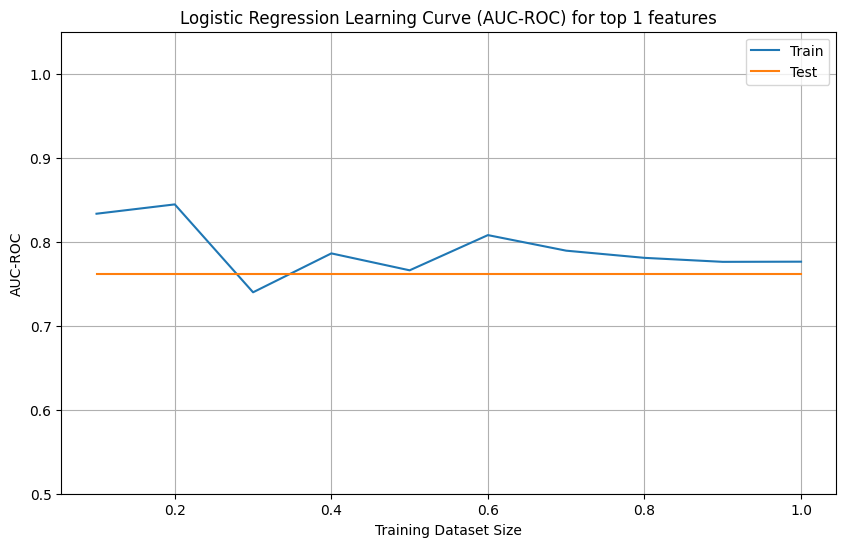

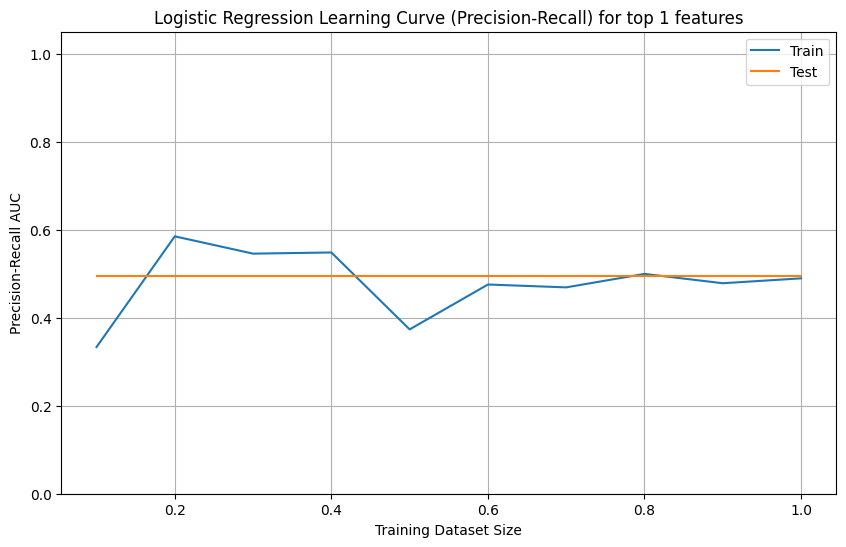

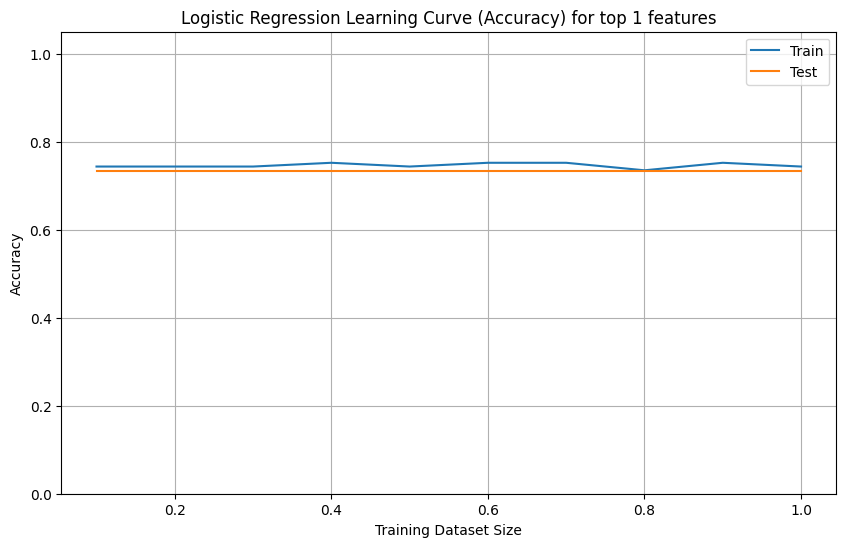

In [ ]:

def train_logistic_regression(X_train_subset, y_train_subset, X_test_subset, y_test, class_weights):
    # Initialize a logistic regression model
    lr_model = LogisticRegression(class_weight=class_weights, random_state=0)

    # Define hyperparameters to search over
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga']
    }

    # Perform GridSearchCV for hyperparameter optimization
    grid_search = GridSearchCV(lr_model, param_grid, cv=5)
    grid_search.fit(X_train_subset, y_train_subset)

    # Get the best model from GridSearchCV
    best_lr_model = grid_search.best_estimator_
    print("LR best parameter :", best_lr_model)

    # Fit the best model on the full training set
    best_lr_model.fit(X_train_subset, y_train_subset)

    # Predict probabilities for training and test sets
    y_train_pred_proba = best_lr_model.predict_proba(X_train_subset)[:, 1]
    y_test_pred_proba = best_lr_model.predict_proba(X_test_subset)[:, 1]

    # Calculate AUC-ROC scores
    train_auc = roc_auc_score(y_train_subset, y_train_pred_proba)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)

    # Calculate precision-recall scores
    train_precision, train_recall, _ = precision_recall_curve(y_train_subset, y_train_pred_proba)
    test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_pred_proba)

    # Calculate AUC-PR scores
    train_auc_pr = auc(train_recall, train_precision)
    test_auc_pr = auc(test_recall, test_precision)

    return best_lr_model, train_auc, test_auc, train_auc_pr, test_auc_pr

def plot_learning_curve(train_sizes, train_scores, test_scores, title, xlabel, ylabel, ylim=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores, label='Train')
    plt.plot(train_sizes, test_scores, label='Test')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()

def back_to_basic_mod(X, y, feature_importance):

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test, class_weights, weights = pipeline.fit_transform(X, y)

    # Set number of top features
    num_top_f = 1
    # Select top feature
    feature_importance_list = feature_importance.iloc[:, 0]
    selected_features = feature_importance_list[:num_top_f]  # Get features

    # Train model with top features
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]

    # Initialize lists to store results
    train_auc_roc_scores = []
    test_auc_roc_scores = []
    train_precision_scores = []
    test_precision_scores = []
    train_accuracy_scores = []  # New list for accuracy scores
    test_accuracy_scores = []  # New list for accuracy scores

    # Vary training dataset size from 10% to 100%
    dataset_sizes = np.linspace(0.1, 1.0, 10)

    for size in dataset_sizes:
        num_samples = int(len(X_train) * size)
        X_train_subsubset, y_train_subset = X_train_subset[:num_samples], y_train[:num_samples]

        # Train logistic regression model and evaluate
        best_lr_model, train_auc, test_auc, train_auc_pr, test_auc_pr = train_logistic_regression(
            X_train_subsubset, y_train_subset, X_test_subset, y_test, weights)

        # Append scores to lists
        train_auc_roc_scores.append(train_auc)
        test_auc_roc_scores.append(test_auc)
        train_precision_scores.append(train_auc_pr)
        test_precision_scores.append(test_auc_pr)

        # Calculate and store accuracy scores
        y_train_pred = best_lr_model.predict(X_train_subset)
        y_test_pred = best_lr_model.predict(X_test_subset)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        train_accuracy_scores.append(train_accuracy)
        test_accuracy_scores.append(test_accuracy)

    # Plot learning curves
    plot_learning_curve(dataset_sizes, train_auc_roc_scores, test_auc_roc_scores,
                        f'Logistic Regression Learning Curve (AUC-ROC) for top {num_top_f} features', 'Training Dataset Size', 'AUC-ROC', (0.5, 1.05))

    plot_learning_curve(dataset_sizes, train_precision_scores, test_precision_scores,
                        f'Logistic Regression Learning Curve (Precision-Recall) for top {num_top_f} features', 'Training Dataset Size', 'Precision-Recall AUC', (0, 1.05))

    plot_learning_curve(dataset_sizes, train_accuracy_scores, test_accuracy_scores,
                        f'Logistic Regression Learning Curve (Accuracy) for top {num_top_f} features', 'Training Dataset Size', 'Accuracy', (0, 1.05))

    return best_lr_model

# Example usage
best_model = back_to_basic_mod(t_df, y, sorted_features)
